In [218]:
from HeaderP import *

In [219]:
import Astraea

In [402]:
def readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread):
    if simNo=='data':
        data=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
        data['z_today']=data['z']
        data['x_today']=data['X']
        data['y_today']=data['Y']
        data['feh_scale']=data['M_H']
        data['ofe_scale']=data['O_FE']
        data['age']=data['Age']
    elif select:
        data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_apogee_selec.pkl')
        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    
    elif not select:
        if z=='0':
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'.pkl')
        else:
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_z'+z+'.pkl')
            try:
                data['x_today']=data['x']
                data['y_today']=data['y']
                data['z_today']=data['z']
            except:
                print(np.shape(data['x_today']))

        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        
        if Rcut:
            data=data.loc[data['R_bir']<Rcut_thread].reset_index(drop=True)
            data=data.loc[abs(data['z_birth'])<zcut_thread].reset_index(drop=True)
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    return data

def normalize_data(data):
    return (data-np.mean(data))/np.std(data)

# load simulation

In [469]:
simNo='2_79e12'
z='0'
Rcut=True
select=False
Rcut_thread=30
zcut_thread=5


data=readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread)
#data=data.loc[data['age']<3]

# use only [Fe/H] and Age

In [241]:
def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

In [242]:
from itertools import combinations_with_replacement

args = data['feh_scale'], data['age']
args_name = '[Fe/H]', 'Age'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    X_names.append(str(a + '*' + b))
    
    
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(7528957, 5) (5,) 2


In [243]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data['R_bir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

In [244]:
weights = train(y_train, X_train)

(-50.0, 20.0)

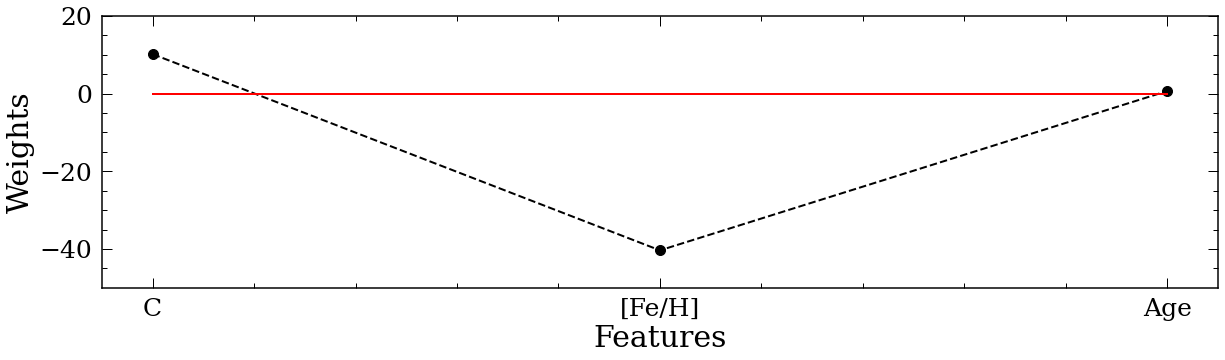

In [245]:
plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)], weights[:(len(args_name)+1)], 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)],np.zeros(len(np.append(['C'],X_names)))[:(len(args_name)+1)],'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-50,20])

(-50.0, 20.0)

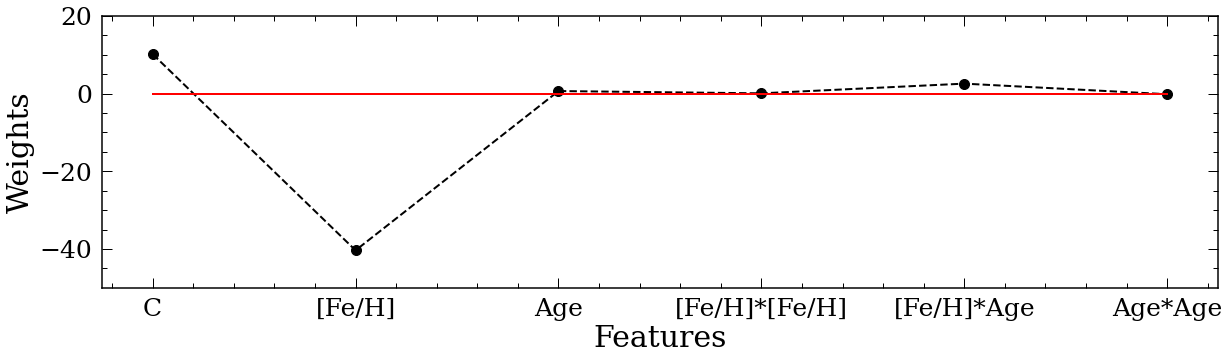

In [246]:
plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names), weights, 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names),np.zeros(len(np.append(['C'],X_names))),'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-50,20])

In [247]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

In [248]:
"""
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
from mlxtend.evaluate import bias_variance_decomp
model = LinearRegression()
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, X_train,
                                                            y_train, X_test,
                                                            y_test,
                                                            loss='mse',
                                                            num_rounds=50,
                                                            random_seed=20)
"""

"\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.datasets import fetch_california_housing\nfrom mlxtend.evaluate import bias_variance_decomp\nmodel = LinearRegression()\navg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, X_train,\n                                                            y_train, X_test,\n                                                            y_test,\n                                                            loss='mse',\n                                                            num_rounds=50,\n                                                            random_seed=20)\n"

Text(0.5, 1.0, 'scatter = 1.85601; bias = -0.00269')

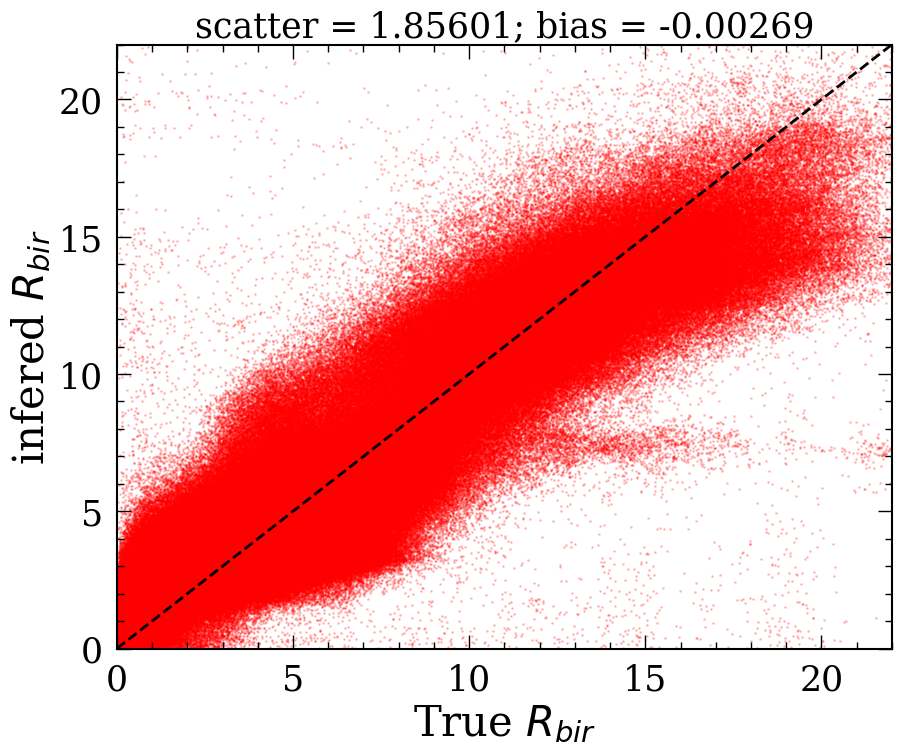

In [249]:
xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_test, y_predict.T, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)

# use [Fe/H], R, and Age

In [546]:
args = normalize_data(data['feh_scale']), normalize_data(data['R']), normalize_data(data['age'])
args_name = '$θ_{[Fe/H]}$', '$θ_R$', '$θ_τ$'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    if a==b=='$θ_{[Fe/H]}$':
        X_names.append('$θ_{[Fe/H]^2}$')
    elif a==b=='$θ_R$':
        X_names.append('$θ_{R^2}$')
    elif a==b=='$θ_τ$':
        X_names.append('$θ_{τ^2}$')
    else:
        X_names.append(str(a + '*' + b))
        
"""
# add in third order terms
X.append(normalize_data(data['age'])*normalize_data(data['R'])*normalize_data(data['feh_scale']))
X_names.append('$θ_{τ*R*[Fe/h]}$')

X.append(normalize_data(data['R'])*normalize_data(data['R'])*normalize_data(data['feh_scale']))
X_names.append('$θ_{R^2*[Fe/h]}$')

X.append(normalize_data(data['age'])*normalize_data(data['age'])*normalize_data(data['feh_scale']))
X_names.append('$θ_{τ^2*[Fe/h]}$')

X.append(normalize_data(data['age'])*normalize_data(data['feh_scale'])*normalize_data(data['feh_scale']))
X_names.append('$θ_{τ*[Fe/h]^2}$')

X.append(normalize_data(data['feh_scale'])*normalize_data(data['R'])*normalize_data(data['feh_scale']))
X_names.append('$θ_{R^2*[Fe/h]}$')

X.append(normalize_data(data['feh_scale'])**3)
X_names.append('$θ_{[Fe/h]^3}$')

X.append(normalize_data(data['age'])**3)
X_names.append('$θ_{τ^3}$')

X.append(normalize_data(data['R'])**3)
X_names.append('$θ_{R^3}$')
"""

"""
# add in τ^0.5 term
X.append(normalize_data(data['age']**0.5))
X_names.append('$θ_{τ^{0.5}}$')
"""
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(7528957, 9) (9,) 3


In [547]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data['R_bir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

In [548]:
weights = train(y_train, X_train)
weights

array([ 7.78806783, -4.56236304,  1.51254159, -3.89548377, -0.01157631,
       -0.37481274,  1.70531447, -0.28612213, -0.41592241, -1.61153549])

(-10.0, 10.0)

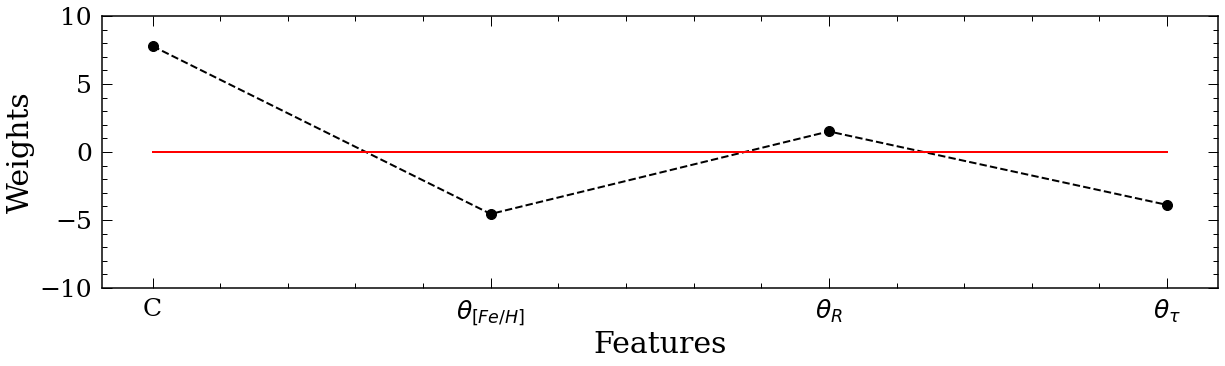

In [549]:
plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)], weights[:(len(args_name)+1)], 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)],np.zeros(len(np.append(['C'],X_names)))[:(len(args_name)+1)],'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-10,10])

### normal polynomial

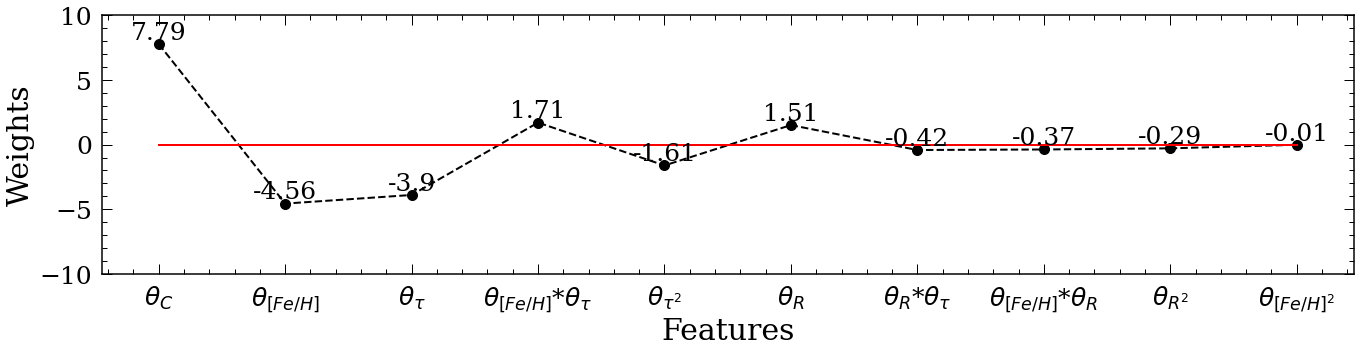

In [550]:
plt.figure(figsize=(19,5))
allnames = np.append(['$θ_C$'],X_names)
absweights, weights_imp, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.plot(allnames, weights_imp, 'k--o', markersize=10)
plt.plot(allnames,np.zeros(len(np.append(['C'],X_names))),'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-10,10])

for i, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (allnames[i], weights_imp[i]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig('importance.png')

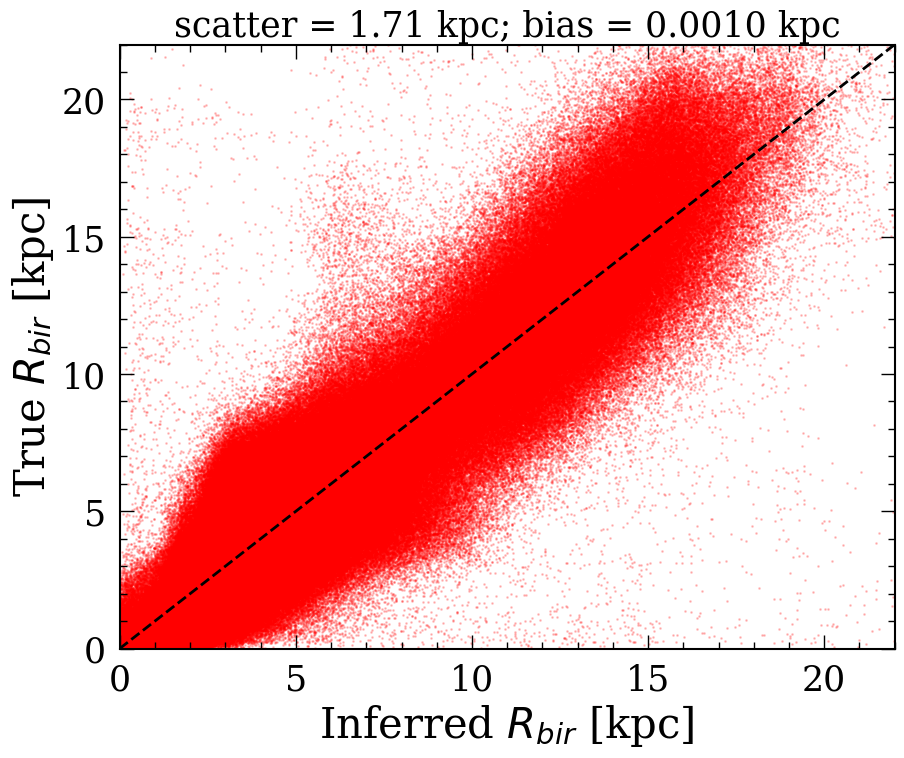

In [551]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_predict.T, y_test, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("Inferred $R_{bir}$ [kpc]")
plt.ylabel("True $R_{bir}$ [kpc]")
plt.title('scatter = %.2f kpc; bias = %.4f kpc'%(scatter, bias),fontsize=25)
plt.savefig('Rbirth.png')

### with τ^0.5 term... 

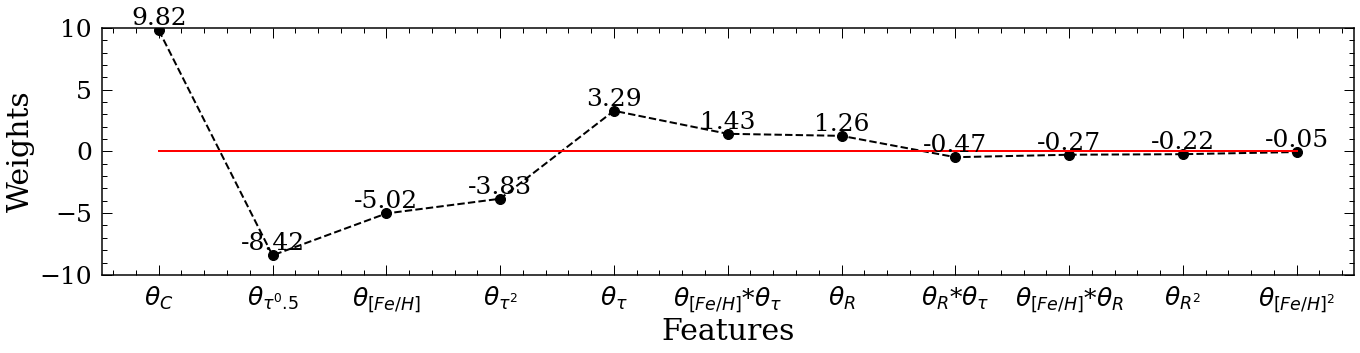

In [544]:
plt.figure(figsize=(19,5))
allnames = np.append(['$θ_C$'],X_names)
absweights, weights_imp, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.plot(allnames, weights_imp, 'k--o', markersize=10)
plt.plot(allnames,np.zeros(len(np.append(['C'],X_names))),'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-10,10])

for i, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (allnames[i], weights_imp[i]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig('importance.png')

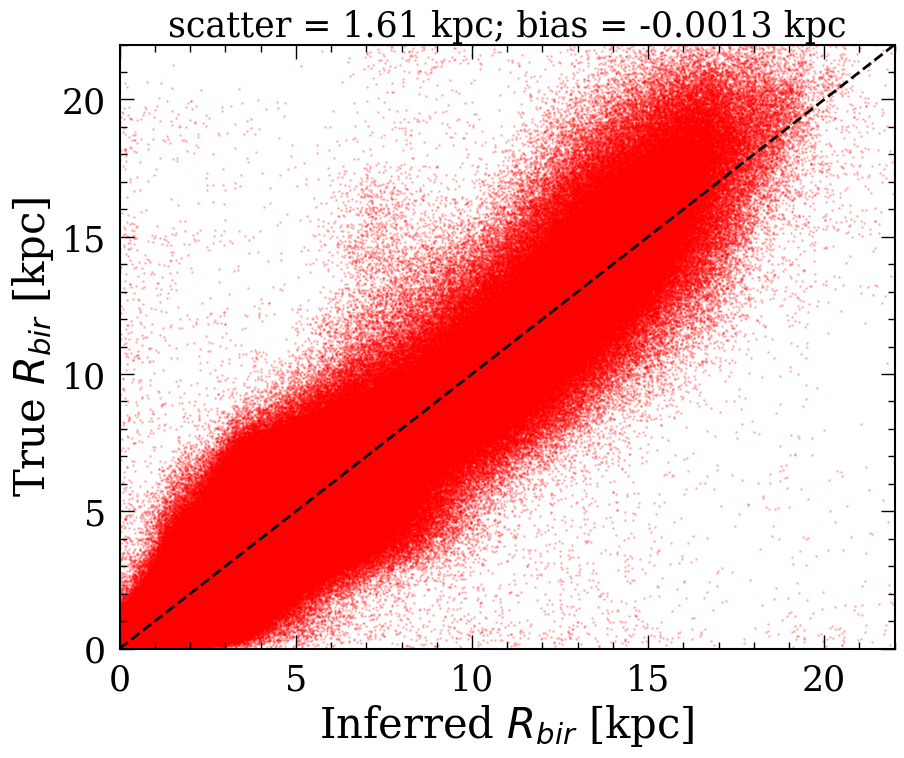

In [545]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_predict.T, y_test, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("Inferred $R_{bir}$ [kpc]")
plt.ylabel("True $R_{bir}$ [kpc]")
plt.title('scatter = %.2f kpc; bias = %.4f kpc'%(scatter, bias),fontsize=25)
plt.savefig('Rbirth.png')

### 3rd order polynomial

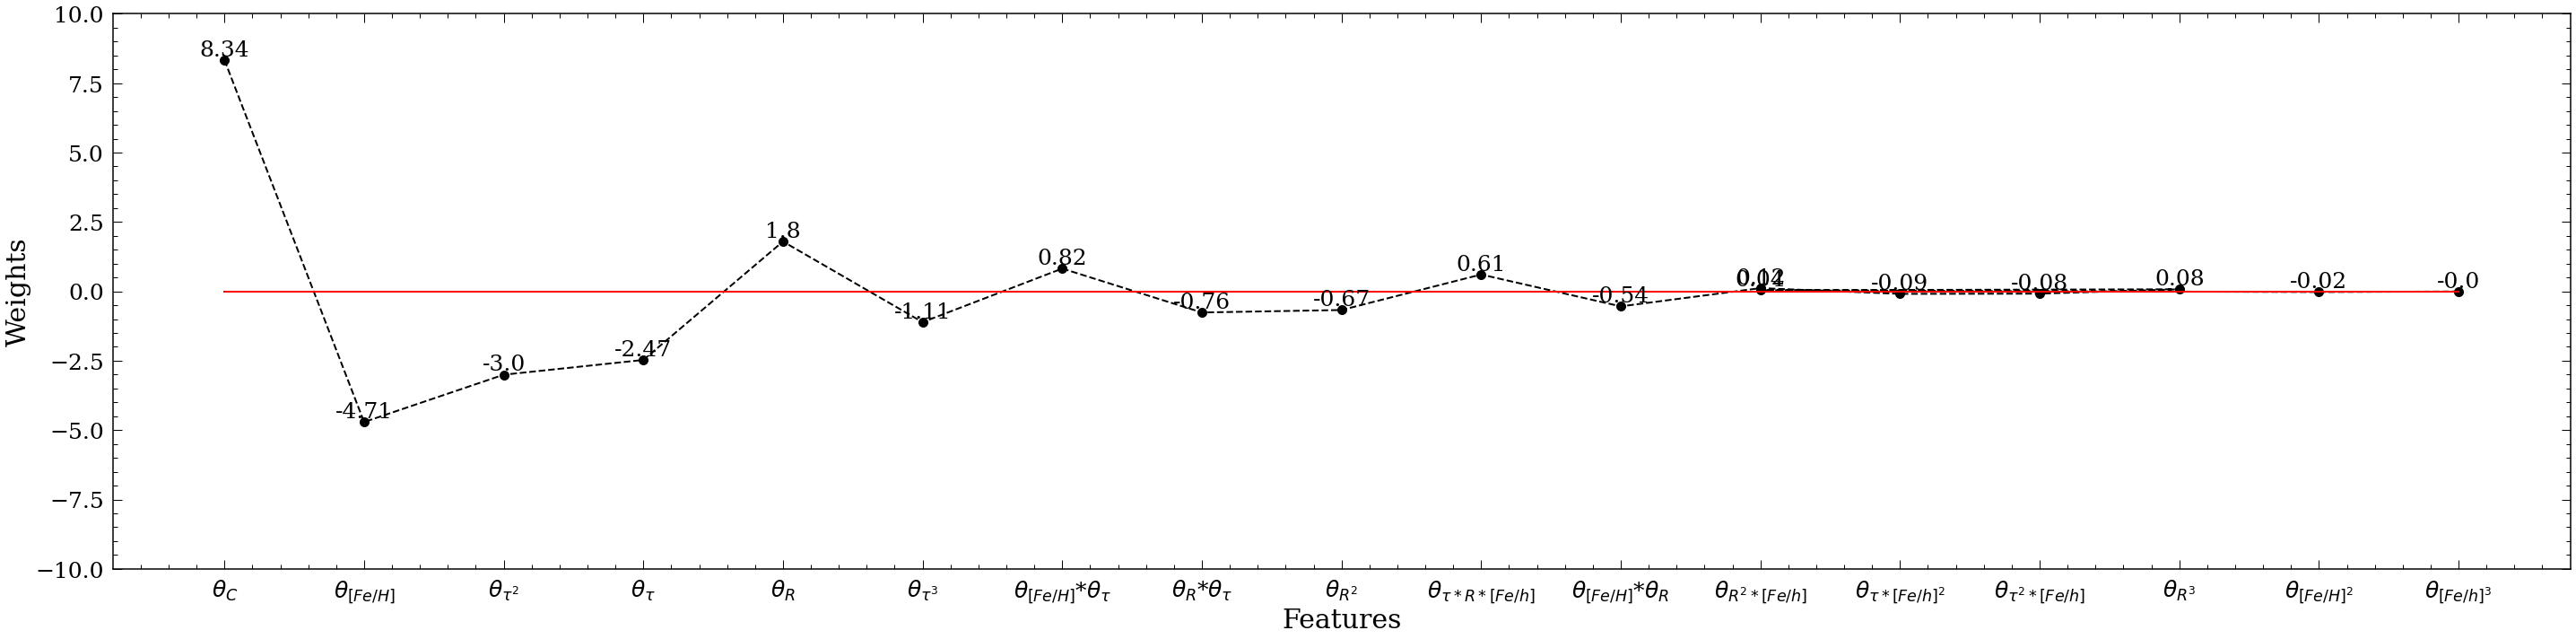

In [517]:
plt.figure(figsize=(40,10))
allnames = np.append(['$θ_C$'],X_names)
absweights, weights_imp, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.plot(allnames, weights_imp, 'k--o', markersize=10)
plt.plot(allnames,np.zeros(len(np.append(['C'],X_names))),'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-10,10])

for i, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (allnames[i], weights_imp[i]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig('importance.png')

In [518]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

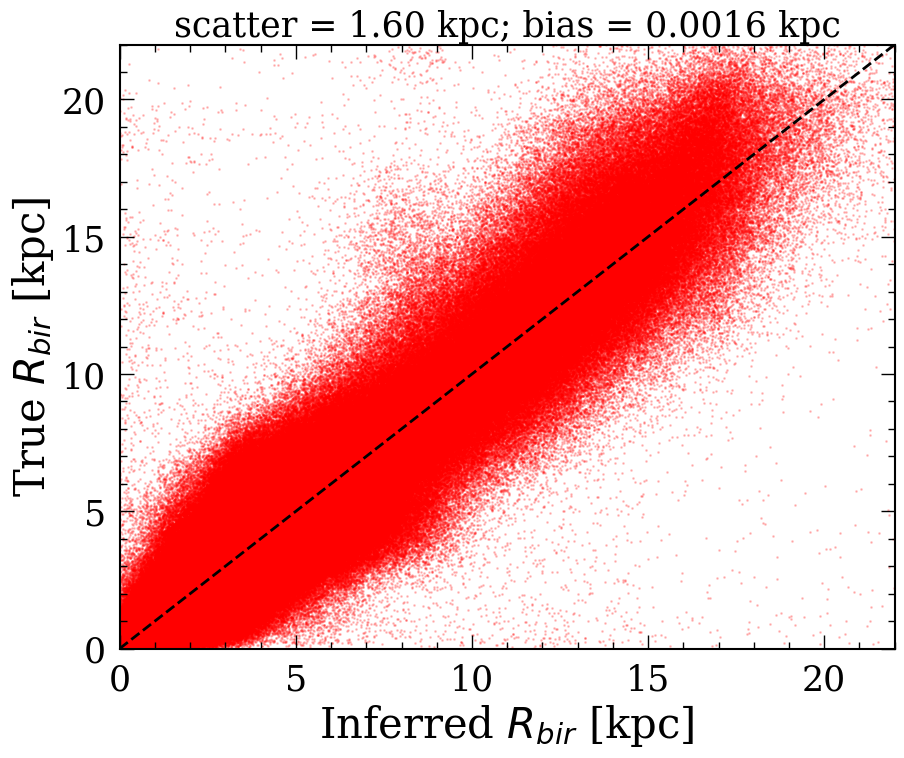

In [519]:
xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_predict.T, y_test, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("Inferred $R_{bir}$ [kpc]")
plt.ylabel("True $R_{bir}$ [kpc]")
plt.title('scatter = %.2f kpc; bias = %.4f kpc'%(scatter, bias),fontsize=25)
plt.savefig('Rbirth.png')

# use [Fe/H], [O/Fe], and Age

In [127]:
args = data['feh_scale'], data['ofe_scale'], data['age']
args_name = '[Fe/H]', '[O/Fe]', 'Age'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    X_names.append(str(a + '*' + b))
    
    
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(7528957, 9) (9,) 3


In [128]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data['R_bir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

In [129]:
weights = train(y_train, X_train)

(-150.0, 150.0)

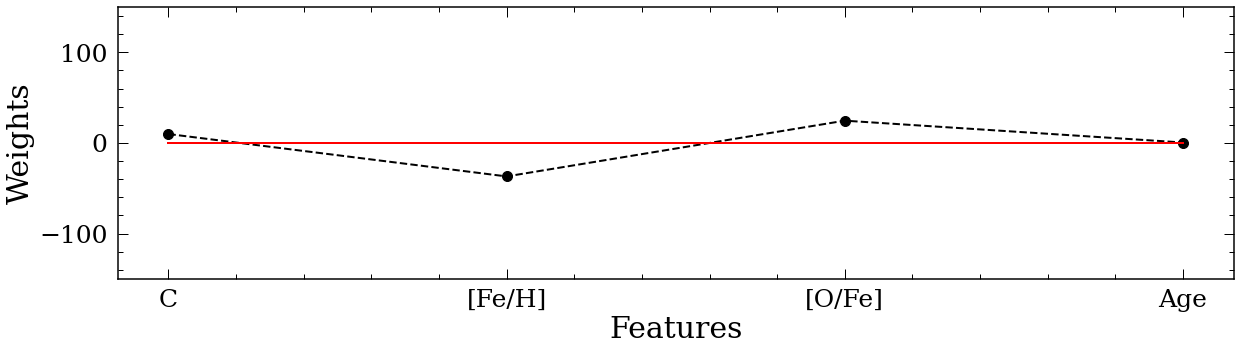

In [130]:
plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)], weights[:(len(args_name)+1)], 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)],np.zeros(len(np.append(['C'],X_names)))[:(len(args_name)+1)],'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-150,150])

In [131]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

Text(0.5, 1.0, 'scatter = 1.81676; bias = -0.00068')

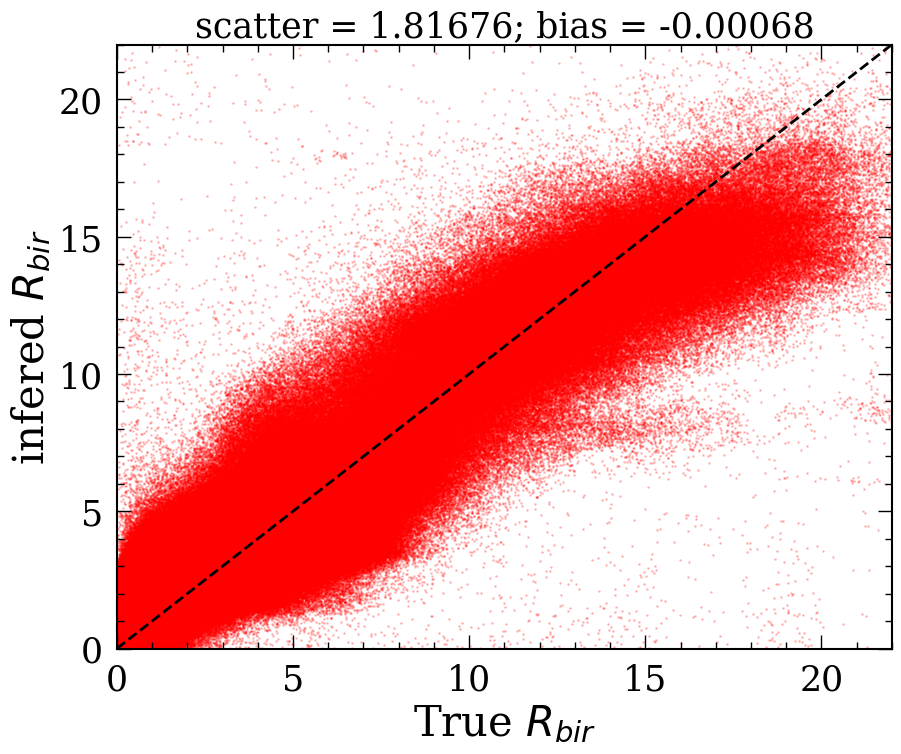

In [132]:
xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_test, y_predict.T, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)

# All features

In [133]:
args = data['feh_scale'], data['ofe_scale'], data['age'], data['vx'], data['vy'], data['vz'], data['x'], data['y'], data['z'], data['mass'], data['Jr'], data['Jphi'], data['Jz'], data['R'] 
args_name = '[Fe/H]', '[O/Fe]', 'Age', 'vx', 'vy', 'vz', 'x', 'y', 'z', 'mass', 'Jr', 'Jphi', 'Jz', 'R'

X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    X_names.append(str(a + '*' + b))
    
    
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))


(7528957, 119) (119,) 14


In [134]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data['R_bir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

In [135]:
weights = train(y_train, X_train)

(-500.0, 500.0)

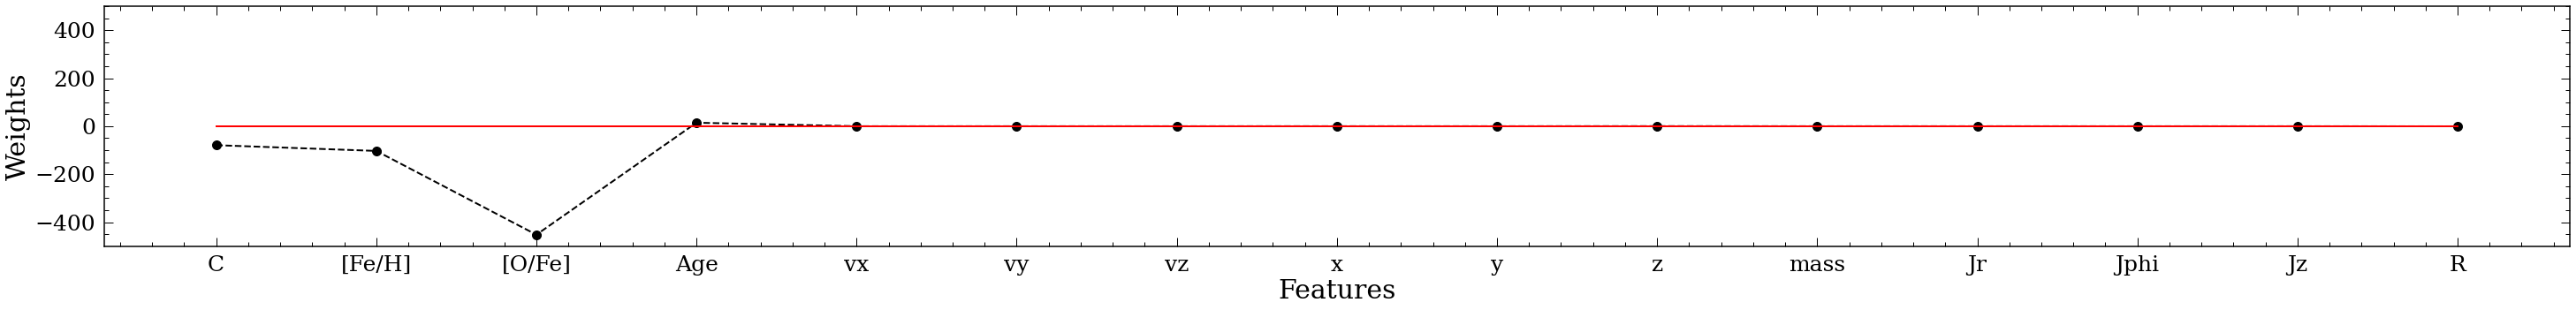

In [136]:
plt.figure(figsize=(50,5))
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)], weights[:(len(args_name)+1)], 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)],np.zeros(len(np.append(['C'],X_names)))[:(len(args_name)+1)],'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-500,500])

In [137]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

Text(0.5, 1.0, 'scatter = 1.52306; bias = 0.00010')

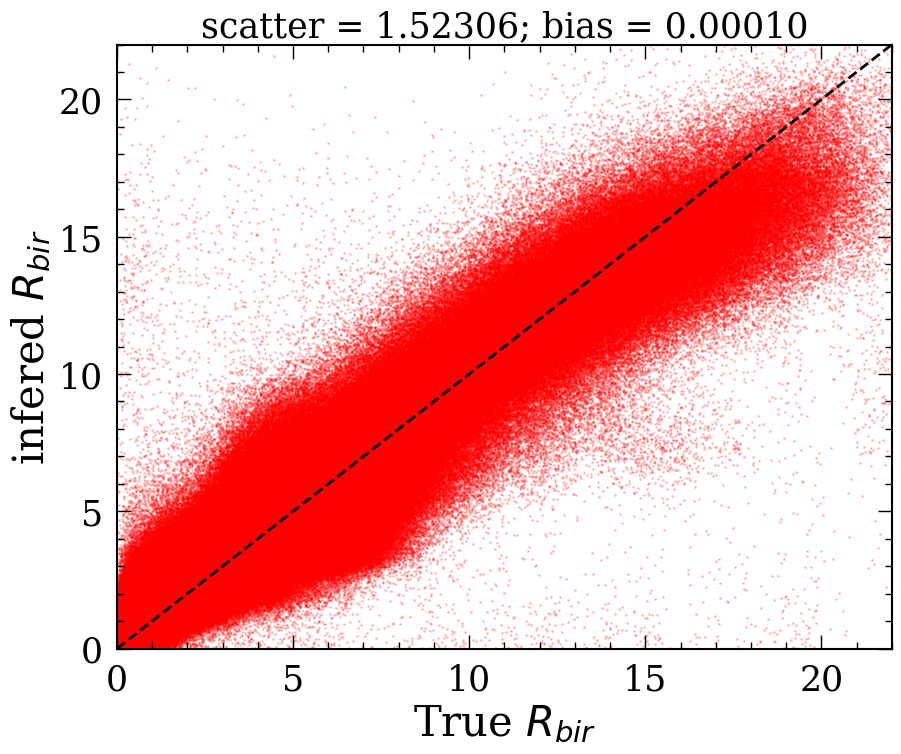

In [138]:
xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_test, y_predict.T, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)

# Try the one with 15 abundances

In [807]:
Rcut_thread=10
data=pd.read_pickle('./Tobias/g8.26e11.pkl')
data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
data['R']=np.sqrt(data['x']**2+data['y']**2)
#data['dR']=data['R']-data['R_bir']

        

In [796]:
args = normalize_data(data['feh']), normalize_data(data['R']), normalize_data(data['age'])
args_name = '$θ_{[Fe/H]}$', '$θ_R$', '$θ_τ$'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    if a==b=='$θ_{[Fe/H]}$':
        X_names.append('$θ_{[Fe/H]^2}$')
    elif a==b=='$θ_R$':
        X_names.append('$θ_{R^2}$')
    elif a==b=='$θ_τ$':
        X_names.append('$θ_{τ^2}$')
    else:
        X_names.append(str(a + '*' + b))
    
    
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(622283, 9) (9,) 3


In [797]:
fehmean, fehstd=np.mean(data['feh']),np.std(data['feh'])
Rmean, Rstd=np.mean(data['R']),np.std(data['R'])
agemean, agestd=np.mean(data['age']),np.mean(data['age'])
Rbirmean, Rbirstd=np.mean(data['Rbir']),np.mean(data['Rbir'])

(-5.0, 5.0)

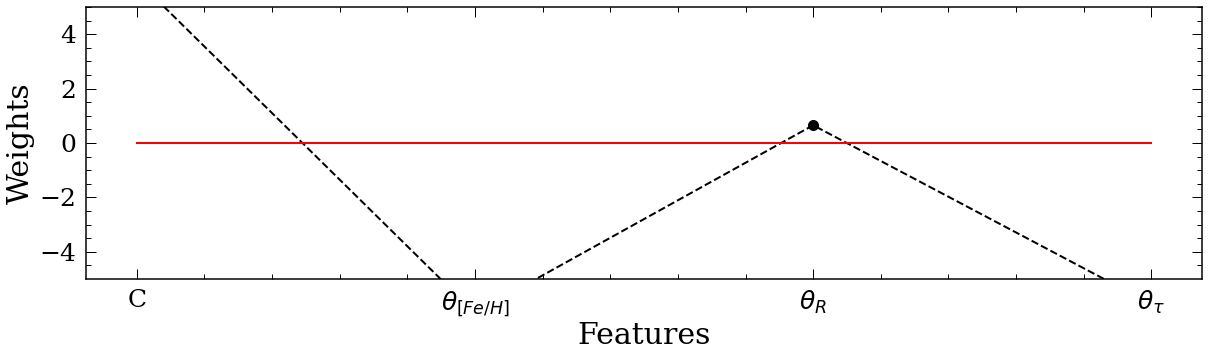

In [569]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data['Rbir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

weights = train(y_train, X_train)

plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)], weights[:(len(args_name)+1)], 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)],np.zeros(len(np.append(['C'],X_names)))[:(len(args_name)+1)],'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-5,5])

(-5.0, 5.0)

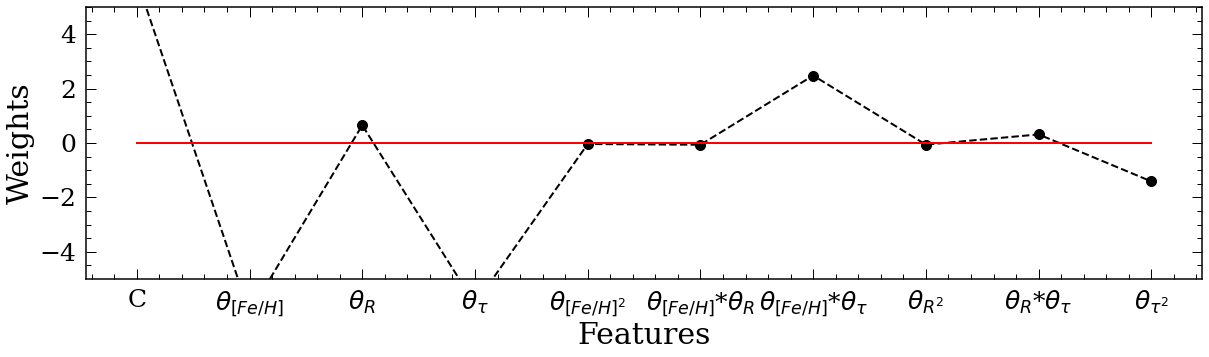

In [570]:
plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names), weights, 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names),np.zeros(len(np.append(['C'],X_names))),'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-5,5])

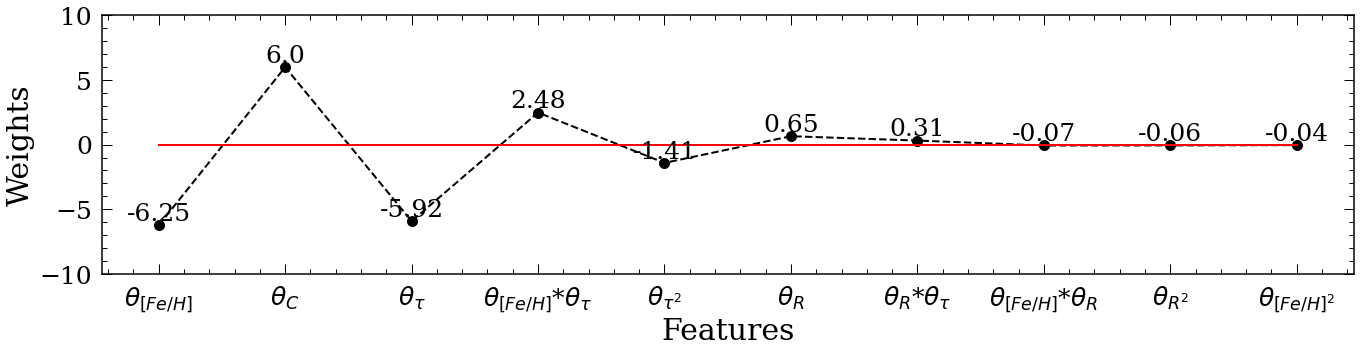

In [574]:
plt.figure(figsize=(19,5))
allnames = np.append(['$θ_C$'],X_names)
absweights, weights_imp, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.plot(allnames, weights_imp, 'k--o', markersize=10)
plt.plot(allnames,np.zeros(len(np.append(['C'],X_names))),'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-10,10])

for i, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (allnames[i], weights_imp[i]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig('importance.png')



In [572]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

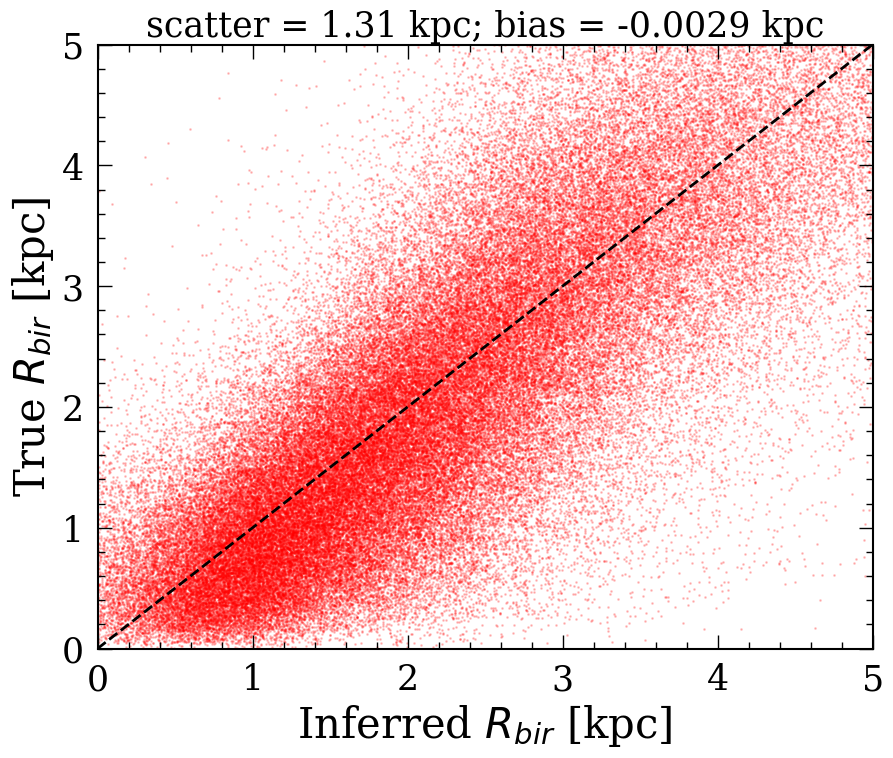

In [573]:
xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_predict.T, y_test, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("Inferred $R_{bir}$ [kpc]")
plt.ylabel("True $R_{bir}$ [kpc]")
plt.title('scatter = %.2f kpc; bias = %.4f kpc'%(scatter, bias),fontsize=25)
plt.savefig('Rbirth.png')

# Try the one with 15 abundances at an earlier snapshot

In [808]:
Stimes = np.load('./Tobias/snapshots.npy')
Ctimes = np.load('./Tobias/cosmictime.npy')

In [809]:
timelookup = {np.round(Ctimes[i],8):Stimes[i] for i in range(len(Ctimes))}
print(Ctimes)

[ 0.23829648  0.45896157  0.67962667  0.90029177  1.12095687  1.34162197
  1.56228707  1.78295216  2.00361726  2.22428236  2.66561256  2.88627766
  3.10694276  3.32760785  3.54827295  3.76893805  3.98960315  4.21026825
  4.43093335  4.65159844  4.87226354  5.09292864  5.31359374  5.53425884
  5.75492394  5.97558903  6.19625413  6.41691923  6.63758433  6.85824943
  7.07891453  7.29957962  7.52024472  7.74090982  7.96157492  8.18224002
  8.40290512  8.62357021  8.84423531  9.06490041  9.28556551  9.50623061
  9.72689571  9.9475608  10.1682259  10.388891   10.6095561  10.8302212
 11.0508863  11.27155139 11.49221649 11.71288159 11.93354669 12.15421179
 12.37487689 12.59554198 12.81620708 13.03687218 13.25753728 13.47820238
 13.69886748 14.14019767]


In [810]:
testtime = 10.1682259

data['R_'+timelookup[testtime]] = np.sqrt(data['x_'+timelookup[testtime]]**2+data['y_'+timelookup[testtime]]**2)
data_ct = data.dropna(subset=['feh','R_'+ timelookup[testtime], 'age', 'Rbir'])
args = normalize_data(data_ct['feh']), normalize_data(data_ct['R_'+timelookup[testtime]]), normalize_data(data_ct['age'])
args_name = '$θ_{[Fe/H]}$', '$θ_R$', '$θ_τ$'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    if a==b=='$θ_{[Fe/H]}$':
        X_names.append('$θ_{[Fe/H]^2}$')
    elif a==b=='$θ_R$':
        X_names.append('$θ_{R^2}$')
    elif a==b=='$θ_τ$':
        X_names.append('$θ_{τ^2}$')
    else:
        X_names.append(str(a + '*' + b))
    

X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(526203, 9) (9,) 3


In [811]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data_ct['Rbir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

In [812]:
weights = train(y_train, X_train)

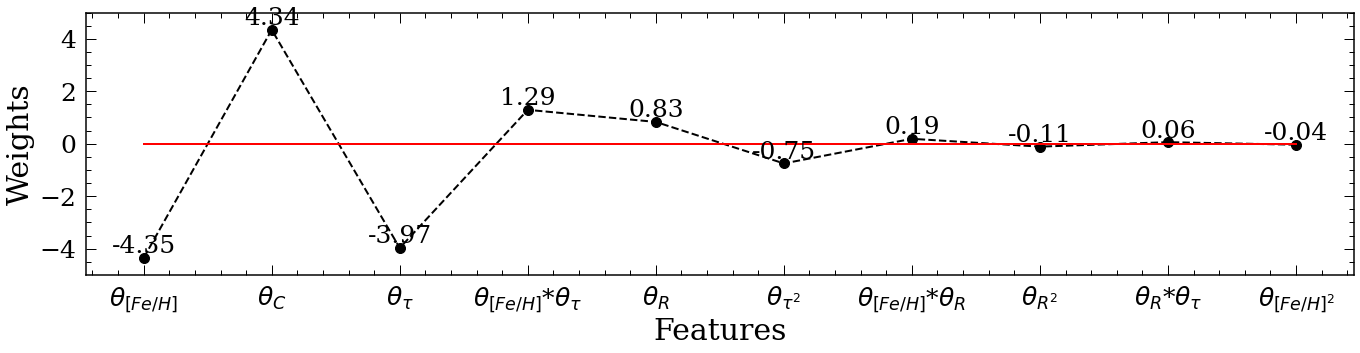

In [813]:
plt.figure(figsize=(19,5))
allnames = np.append(['$θ_C$'],X_names)
absweights, weights_imp, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.plot(allnames, weights_imp, 'k--o', markersize=10)
plt.plot(allnames,np.zeros(len(np.append(['C'],X_names))),'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-5,5])

for i, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (allnames[i], weights_imp[i]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()




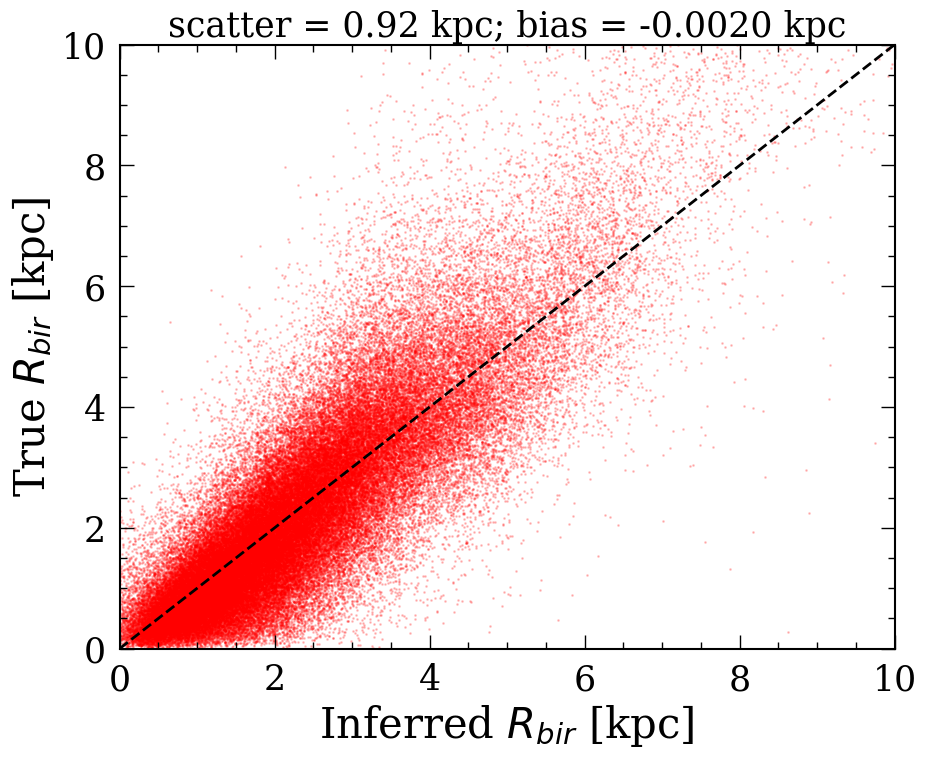

In [814]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_predict.T, y_test, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("Inferred $R_{bir}$ [kpc]")
plt.ylabel("True $R_{bir}$ [kpc]")
plt.title('scatter = %.2f kpc; bias = %.4f kpc'%(scatter, bias),fontsize=25)
plt.savefig('Rbirth.png')

## test all times

In [685]:

weights = np.zeros((len(Ctimes), 10))
scatterings = np.zeros(len(Ctimes))
biases = np.zeros(len(Ctimes))
numbstars = np.zeros(len(Ctimes))

for i, testtime in enumerate(Ctimes):
    print(i)
    testtime = np.round(testtime, 8)
    try: 
        print(len(data['x_'+timelookup[testtime]]))
    except:
        continue
    data['R_'+timelookup[testtime]] = np.sqrt(data['x_'+timelookup[testtime]]**2+data['y_'+timelookup[testtime]]**2)
    data_ct = data.dropna(subset=['feh','R_'+ timelookup[testtime], 'age', 'Rbir'])
    #args = (data_ct['feh']-fehmean)/fehstd, (data_ct['R_'+timelookup[testtime]]-Rmean)/Rstd, (data_ct['age']-agemean)/agestd
    args = data_ct['feh'], data_ct['R_'+timelookup[testtime]], data_ct['age']
    X = list(args)
    for a, b in combinations_with_replacement(args, 2):
        X.append(a * b)

    X = np.array(X).T
    
    
    # Define the number of training and validating stars.
    Ntrain = int(0.8*np.shape(X)[0])
    y = data_ct['Rbir'].values

    # Choose stars at random and split.
    shuffle_inds = np.arange(len(y))
    np.random.shuffle(shuffle_inds)
    train_inds = shuffle_inds[:Ntrain]
    test_inds = shuffle_inds[Ntrain:]
    y_train, X_train = y[train_inds], X[train_inds, :]
    y_test, X_test = y[test_inds], X[test_inds, :]
    
    weights[i, :] = train(y_train, X_train)
    
    A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
    y_predict = np.dot(weights[i, :].T, A.T)
    
    scatterings[i] = np.std(y_test-y_predict)
    biases[i]  = np.mean(y_test-y_predict)
    
    numbstars[i] = len(data_ct)
    #print(numbstars)
 

0
1
622283
[  0. 410.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
2
622283
[   0.  410. 1381.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
3
622283
[   0.  410. 1381. 3652.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.   

[     0.    410.   1381.   3652.   6271.  10654.  18040.  26619.  36399.
      0.  82507.  99309. 113551. 133519. 150810. 172252. 194979. 217358.
 239925. 259680. 280814.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.]
21
622283
[     0.    410.   1381.   3652.   6271.  10654.  18040.  26619.  36399.
      0.  82507.  99309. 113551. 133519. 150810. 172252. 194979. 217358.
 239925. 259680. 280814. 298545.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.

[0.00000e+00 4.10000e+02 1.38100e+03 3.65200e+03 6.27100e+03 1.06540e+04
 1.80400e+04 2.66190e+04 3.63990e+04 0.00000e+00 8.25070e+04 9.93090e+04
 1.13551e+05 1.33519e+05 1.50810e+05 1.72252e+05 1.94979e+05 2.17358e+05
 2.39925e+05 2.59680e+05 2.80814e+05 2.98545e+05 3.14877e+05 3.31638e+05
 3.49651e+05 3.64684e+05 3.80087e+05 3.94613e+05 4.06478e+05 4.18321e+05
 4.28785e+05 4.38583e+05 4.47821e+05 4.57597e+05 4.66050e+05 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00]
35
622283
[0.00000e+00 4.10000e+02 1.38100e+03 3.65200e+03 6.27100e+03 1.06540e+04
 1.80400e+04 2.66190e+04 3.63990e+04 0.00000e+00 8.25070e+04 9.93090e+04
 1.13551e+05 1.33519e+05 1.50810e+05 1.72252e+05 1.94979e+05 2.17358e+05
 2.39925e+05 2.

KeyboardInterrupt: 

In [682]:
print(fehmean, fehstd)
print(Rmean, Rstd)
print(agemean, agestd)
print(Rbirmean, Rbirstd)

-0.07614406468613552 0.37627347396143046
3.142622366078975 3.3146858109901562
8.180690439957258 8.180690439957258
2.615251632383737 2.615251632383737


In [689]:
#weights, scatterings, biases, numbstars = np.save('weights_noNorm',weights), np.save('scatterings_noNorm',scatterings), np.save('biases_noNorm',biases), np.save('numbstars_noNorm',numbstars)

#weights, scatterings, biases, numbstars = np.load('weights.npy'), np.load('scatterings.npy'), np.load('biases.npy'), np.load('numbstars.npy')
weights, scatterings, biases, numbstars = np.load('weights_noNorm.npy'), np.load('scatterings_noNorm.npy'), np.load('biases_noNorm.npy'), np.load('numbstars_noNorm.npy')

m_filt = (scatterings!=0)
weights, scatterings, biases, numbstars = np.array(weights[m_filt,:]), np.array(scatterings[m_filt]), np.array(biases[m_filt]), np.array(numbstars[m_filt])
lookbacktime = Ctimes[m_filt]


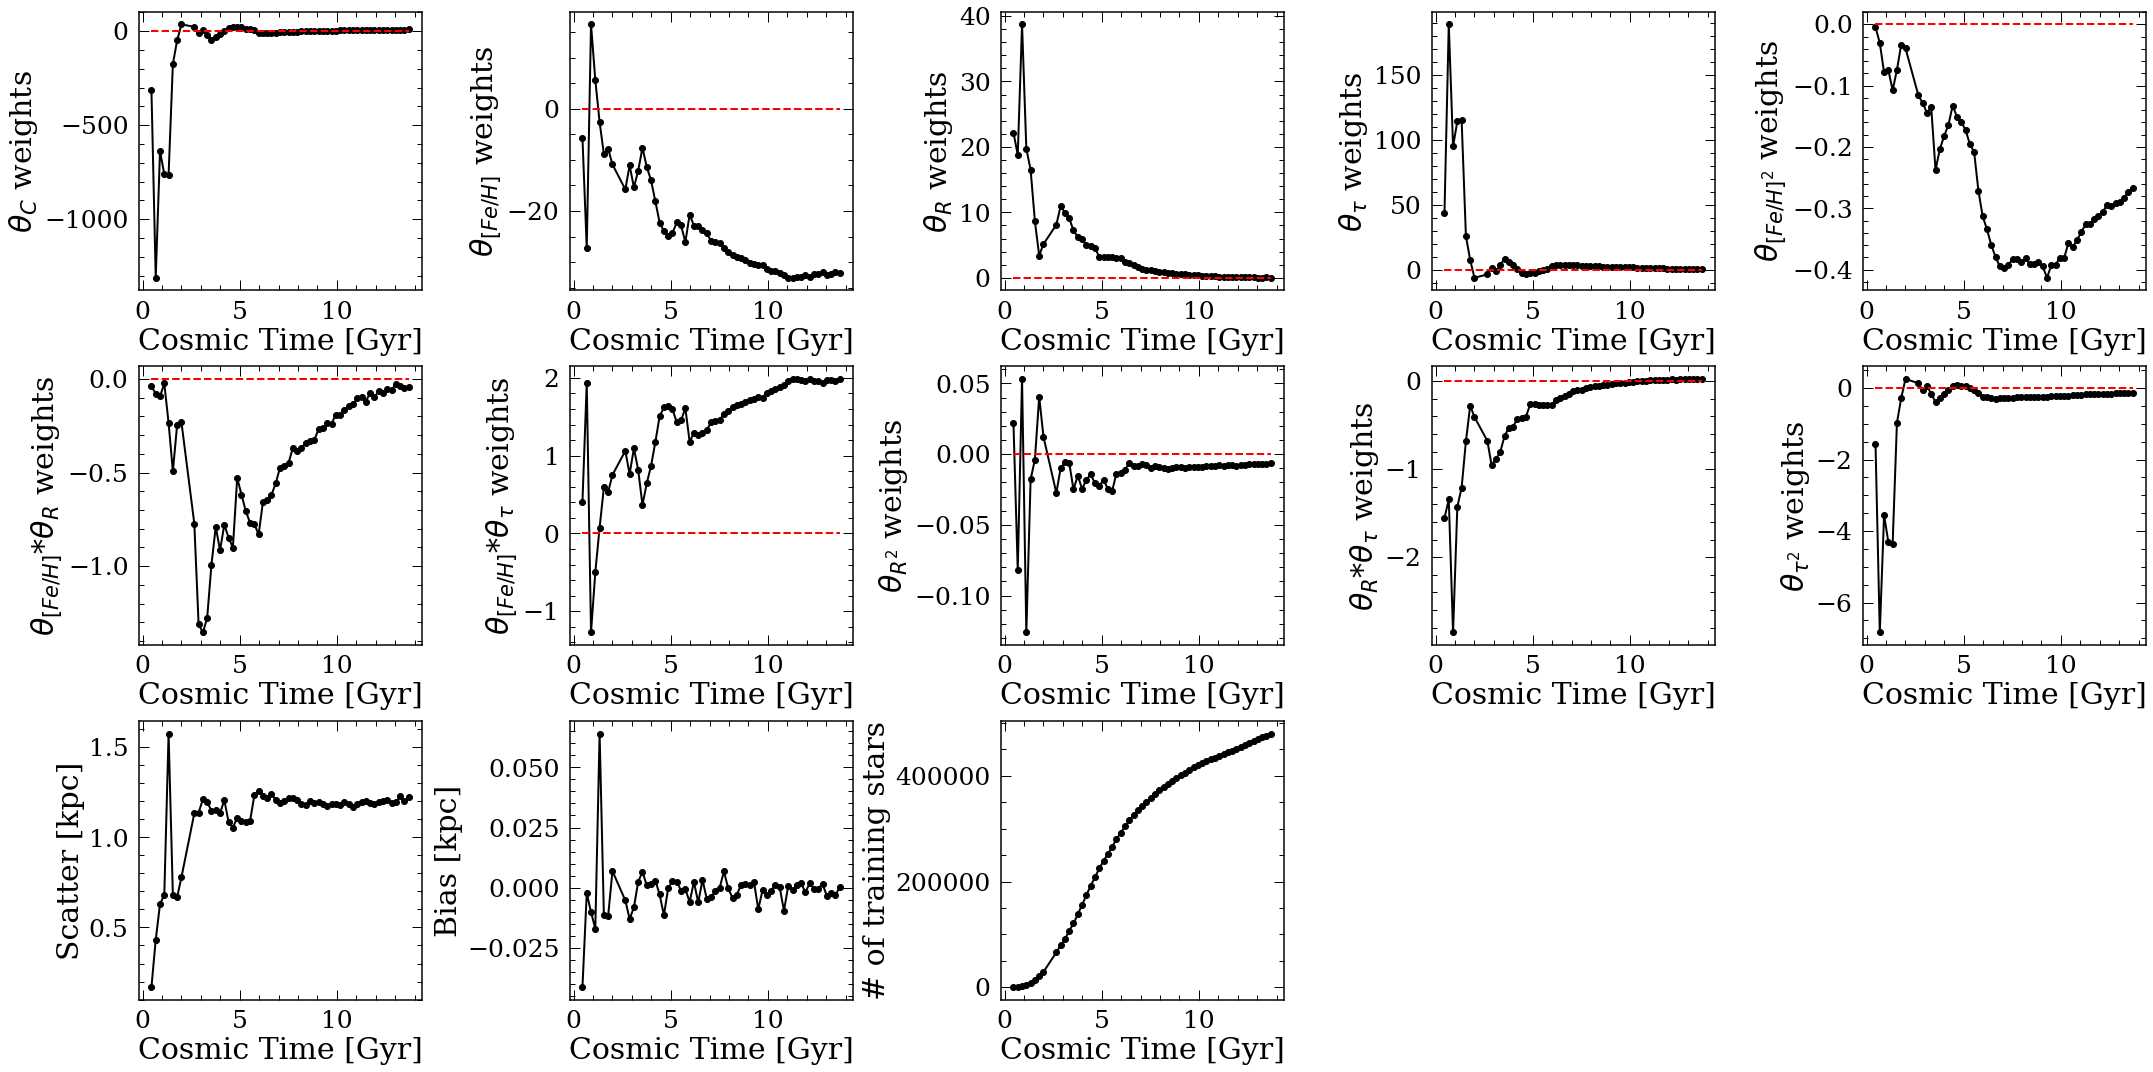

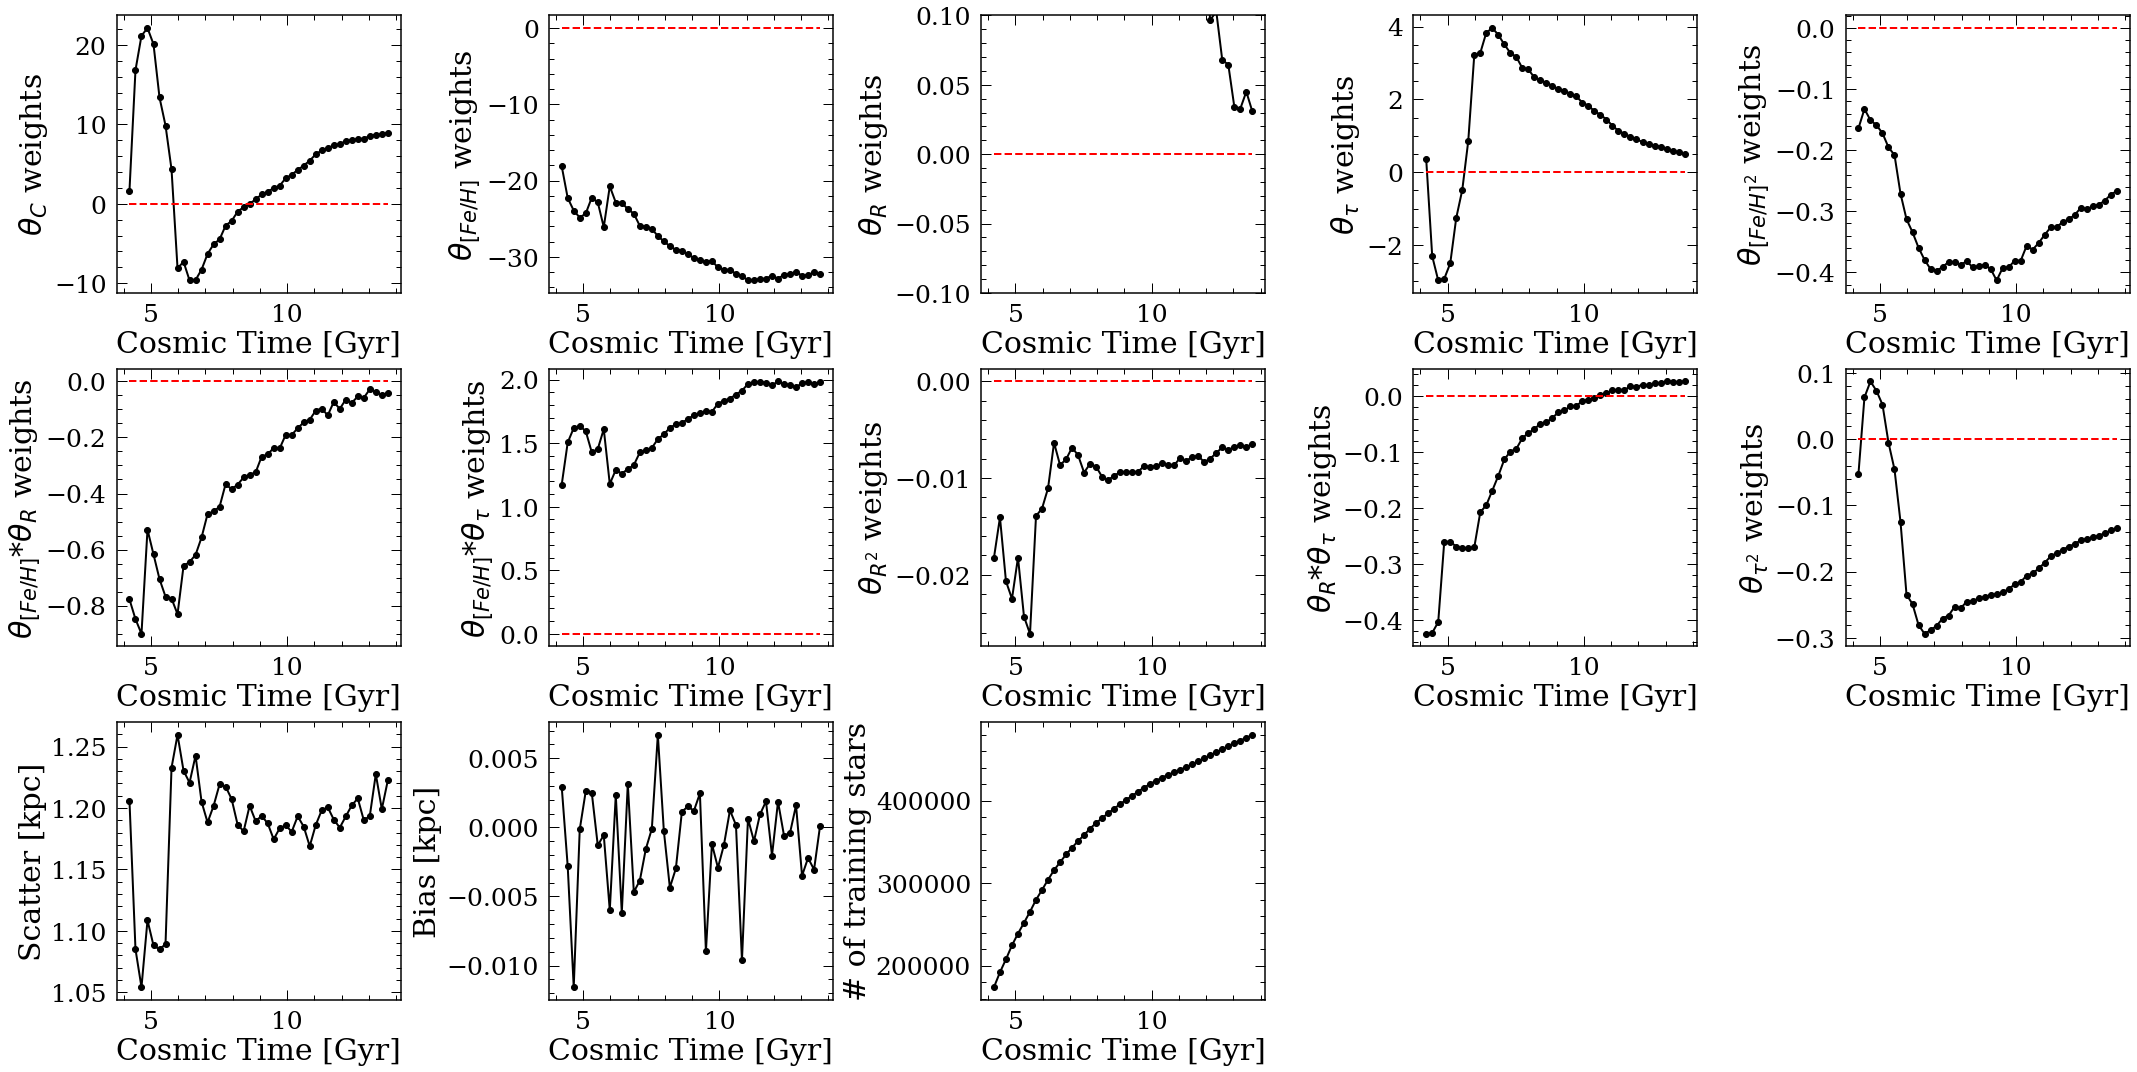

In [694]:
plt.figure(figsize=(30,15))
allnames = np.append(['$θ_C$'],X_names)
for i in range(len(allnames)):
    plt.subplot(3,5,i+1)
    plt.plot(lookbacktime, weights[:,i],'ko-')
    plt.plot(lookbacktime, np.zeros(len(lookbacktime)), 'r--')
    plt.xlabel('Cosmic Time [Gyr]')
    plt.ylabel(allnames[i]+' weights')

plt.subplot(3,5,11)
plt.plot(lookbacktime, scatterings,'ko-')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('Scatter [kpc]')

plt.subplot(3,5,12)
plt.plot(lookbacktime, biases,'ko-')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('Bias [kpc]')

plt.subplot(3,5,13)
plt.plot(lookbacktime, numbstars*0.8,'ko-')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('# of training stars')

plt.tight_layout()
plt.savefig('time_evolution.png')




### only with > 1000000 stars
m_ns = (numbstars>200000)
plt.figure(figsize=(30,15))
allnames = np.append(['$θ_C$'],X_names)
for i in range(len(allnames)):
    plt.subplot(3,5,i+1)
    plt.plot(lookbacktime[m_ns], weights[:,i][m_ns],'ko-')
    plt.plot(lookbacktime[m_ns], np.zeros(len(lookbacktime[m_ns])), 'r--')
    plt.xlabel('Cosmic Time [Gyr]')
    plt.ylabel(allnames[i]+' weights')
    if allnames[i]=='$θ_R$':
        plt.ylim([-0.1,0.1])

plt.subplot(3,5,11)
plt.plot(lookbacktime[m_ns], scatterings[m_ns],'ko-')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('Scatter [kpc]')

plt.subplot(3,5,12)
plt.plot(lookbacktime[m_ns], biases[m_ns],'ko-')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('Bias [kpc]')

plt.subplot(3,5,13)
plt.plot(lookbacktime[m_ns], numbstars[m_ns]*0.8,'ko-')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('# of training stars')

plt.tight_layout()

# Use all abundances

In [1205]:
abundcolm = [i for i in data_ct.columns if ('fe' in i) and (i!='feh')]
#abundcolm = abundcolm[:2]
data_ct = data.dropna(subset=np.append(['feh','R', 'age', 'Rbir'],abundcolm))

args = data_ct[['feh','R', 'age']].values.T
args_name = '$θ_{[Fe/H]}$', '$θ_R$', '$θ_τ$'

X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    if a==b=='$θ_{[Fe/H]}$':
        X_names.append('$θ_{[Fe/H]^2}$')
    elif a==b=='$θ_R$':
        X_names.append('$θ_{R^2}$')
    elif a==b=='$θ_τ$':
        X_names.append('$θ_{τ^2}$')
    else:
        X_names.append(str(a + '*' + b))
"""
for i in range(len(abundcolm)):
    X.append(data_ct[abundcolm[i]])
    X_names.append('$θ_'+'{'+abundcolm[i]+'}$')
"""        
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(613694, 9) (9,) 3


In [654]:
for i in range(np.shape(X)[1]):
    X[:,i] = normalize_data(X[:,i])

In [655]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = normalize_data(data_ct['Rbir'].values)

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

In [656]:
weights = train(y_train, X_train)

### Add in all abundances in linear terms

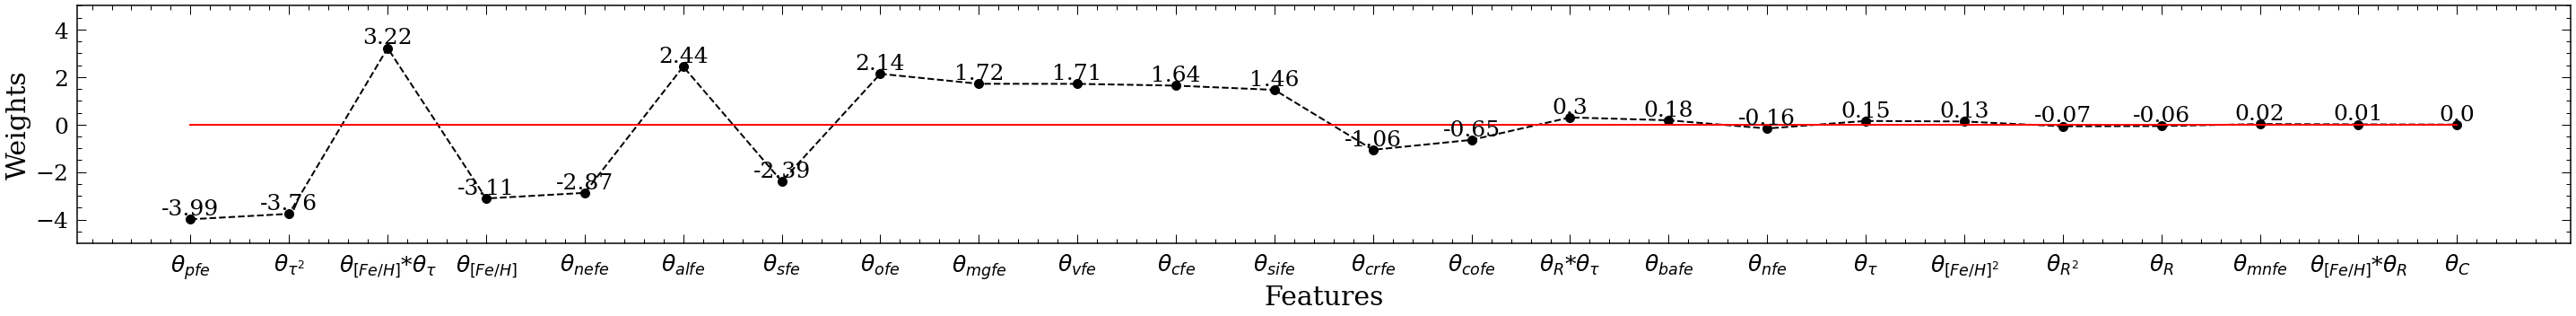

In [651]:
plt.figure(figsize=(40,5))
allnames = np.append(['$θ_C$'],X_names)
absweights, weights_imp, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.plot(allnames, weights_imp, 'k--o', markersize=10)
plt.plot(allnames,np.zeros(len(np.append(['C'],X_names))),'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-5,5])

for i, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (allnames[i], weights_imp[i]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()





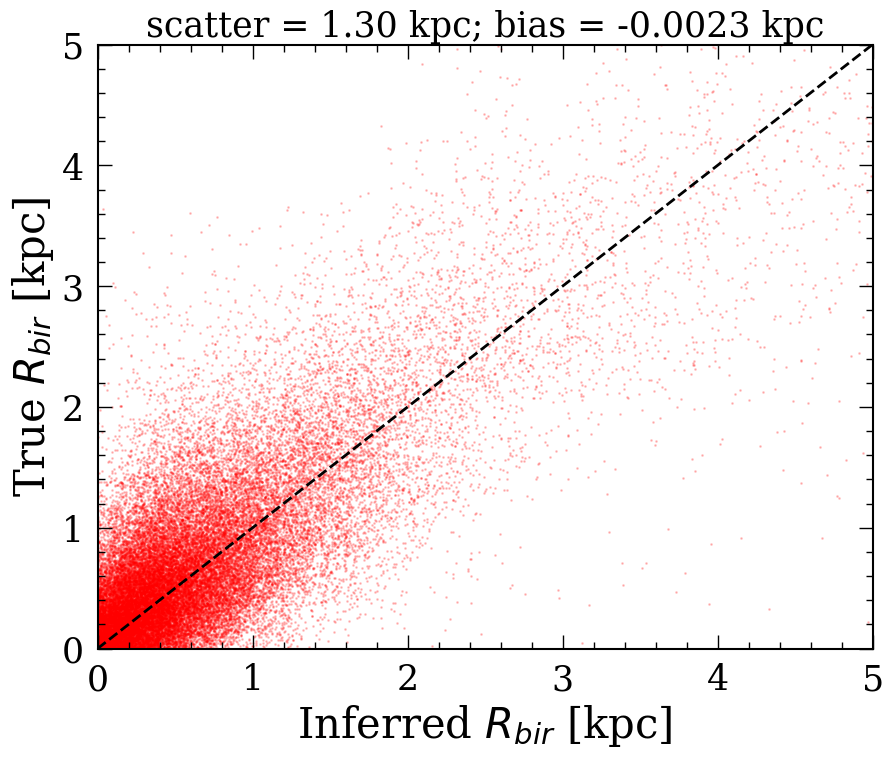

In [652]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_predict.T, y_test, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("Inferred $R_{bir}$ [kpc]")
plt.ylabel("True $R_{bir}$ [kpc]")
plt.title('scatter = %.2f kpc; bias = %.4f kpc'%(scatter, bias),fontsize=25)
plt.savefig('Rbirth.png')

# Test analytic solutions

## Minchev2018

for $\tau$ ~ $\tau_0$:

- $R_b ~ R_0 - \frac{b}{a}$

for $\tau$ << $\tau_0$:

- $R_b$ ~ $\frac{1}{c_m}\rm{[Fe/H]} + (\frac{b}{C_m}-\frac{a C_b}{C_m^2})(\tau/\tau_0) + \frac{a}{C_m^2}\rm{[Fe/H]}(\tau/\tau_0) - \frac{C_b}{C_m}[(\frac{a}{C_m})^2 + \frac{a}{2 C_m})](\tau/\tau_0)^2 + R_0 - \frac{C_b}{C_m}$


$C_m := \nabla\rm{[Fe/H]}(0)$; $C_b := \rm{[Fe/H]}(R_0, 0)$

In [1643]:
from sympy import init_printing, symbols, Function
x, h = symbols("x,h")


In [1625]:
t0 = 14.1
R0 = 6
data_ct = data.loc[(data['age'])<2]
data_ct = data_ct.loc[abs(data_ct['R']-R0)<0.2]
data_ct = data_ct.dropna(subset=['feh','R', 'age', 'Rbir'])
args = data_ct['feh'], data_ct['R'], data_ct['age']/t0
args_name = '$θ_{[Fe/H]}$', '$θ_R$', '$θ_τ$'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    if a==b=='$θ_{[Fe/H]}$':
        X_names.append('$θ_{[Fe/H]^2}$')
    elif a==b=='$θ_R$':
        X_names.append('$θ_{R^2}$')
    elif a==b=='$θ_τ$':
        X_names.append('$θ_{τ^2}$')
    else:
        X_names.append(str(a + '*' + b))
    

X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(724, 9) (9,) 3


In [1626]:
X_names

['$θ_{[Fe/H]}$',
 '$θ_R$',
 '$θ_τ$',
 '$θ_{[Fe/H]^2}$',
 '$θ_{[Fe/H]}$*$θ_R$',
 '$θ_{[Fe/H]}$*$θ_τ$',
 '$θ_{R^2}$',
 '$θ_R$*$θ_τ$',
 '$θ_{τ^2}$']

In [1627]:
X = np.array(X)[:,np.array([1,0,1,0,0,1,0,0,1], dtype=bool)]
X_names = np.array(X_names)[np.array([1,0,1,0,0,1,0,0,1], dtype=bool)]

X_names

array(['$θ_{[Fe/H]}$', '$θ_τ$', '$θ_{[Fe/H]}$*$θ_τ$', '$θ_{τ^2}$'],
      dtype='<U18')

In [1628]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data_ct['Rbir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

weights = train(y_train, X_train)

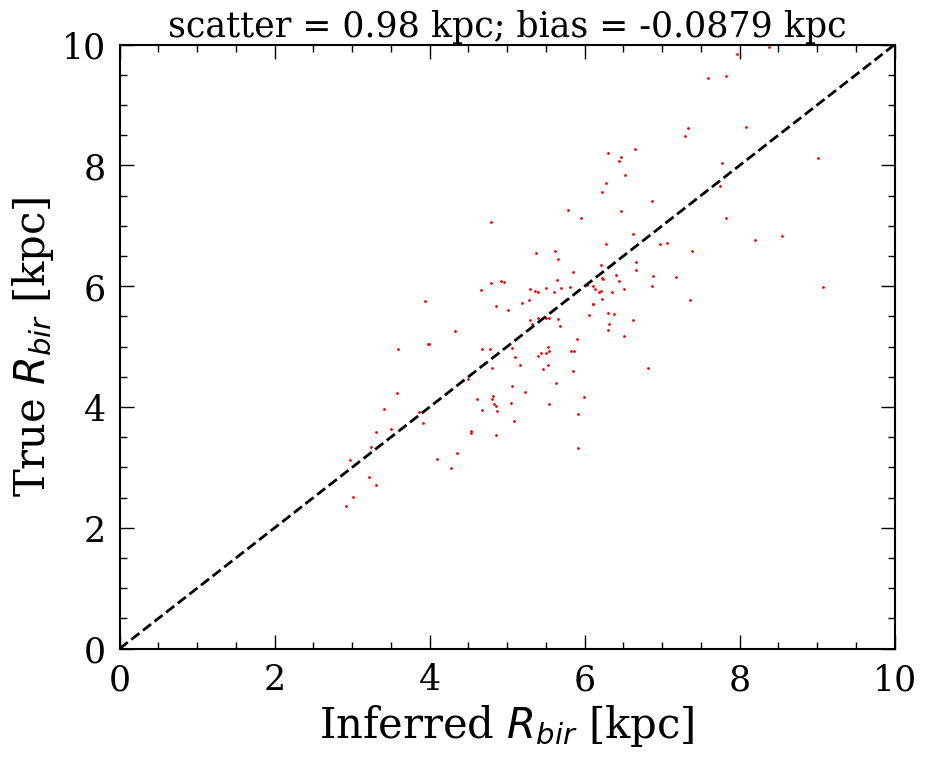

In [1629]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_predict.T, y_test, s=1, c='r')
plt.plot(xs, xs, "k--")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("Inferred $R_{bir}$ [kpc]")
plt.ylabel("True $R_{bir}$ [kpc]")
plt.title('scatter = %.2f kpc; bias = %.4f kpc'%(scatter, bias),fontsize=25)
plt.savefig('Rbirth.png')

In [1630]:
allnames = np.append(['$θ_C$'],X_names)
lasttao = {allnames[i]:weights[i] for i in range(len(allnames))}

lasttao, len(allnames)

({'$θ_C$': 7.187348937447032,
  '$θ_{[Fe/H]}$': -9.859358135395185,
  '$θ_τ$': 6.1637923887846915,
  '$θ_{[Fe/H]}$*$θ_τ$': -92.03542810455549,
  '$θ_{τ^2}$': 14.108398891815588},
 5)

### calculate all the constants based on the coefficients

In [1631]:
print('assumed τ0 = 12 Gyr, R0 = 6:')
print('\n')
cm = 1/lasttao['$θ_{[Fe/H]}$']
print('cm', cm)
a = lasttao['$θ_{[Fe/H]}$*$θ_τ$']*cm**2
print('a', a)
cb = -((lasttao['$θ_C$']-R0)*cm)
print('cb', cb)
b = (lasttao['$θ_τ$']+a*cb/cm**2)*cm
print('b', b)

print('\n')
print('theory θ_τ^2', -(cb/cm)*((a/cm)**2+a/2/cm)+(2*a+cm)*(b)/2/cm**2)
print('real θ_τ^2', lasttao['$θ_{τ^2}$'])
print('\n')

print('theory R0-b/a',R0-b/a)

assumed τ0 = 12 Gyr, R0 = 6:


cm -0.10142648093997021
a -0.9467989159392205
cb 0.12042862437306529
b 0.49900891557743143


theory θ_τ^2 60.61984779925729
real θ_τ^2 14.108398891815588


theory R0-b/a 6.527048465283061


### test these values on the $\tau$ ~ $\tau0$ limit for Rb, and to test the slope and [Fe/H] around R0

In [1632]:
data_t0 = data.loc[abs(data['age']-12)>1]
data_t0 = data_t0.loc[abs(data_t0['R']-R0)<0.2]
print(np.shape(data_t0))
data_t0 = data_t0.sort_values(by='R')

"""
r = data_ct['R'].rolling(100).median().dropna().values
feh = data_ct['feh'].rolling(100).median().dropna().values
rbir = data_ct['Rbir'].rolling(100).median().dropna().values
"""
r = data_t0['R'].dropna().values
rbir = data_t0['Rbir'].dropna().values
rbir_rm = data_t0['Rbir'].rolling(1000).median().dropna().values
r_rm = data_t0['R'].rolling(1000).median().dropna().values
feh_t0 = data_t0['feh'].dropna().values

r_feh_rm = data['R'].rolling(1000).median().dropna().values
feh_rm = data['feh'].rolling(1000).median().dropna().values
r_feh = data['R'].dropna().values
feh = data['feh'].dropna().values

print(len(r),len(r_feh))

(6940, 742)
6940 613694


In [1633]:
p = fitpoints(r, rbir)

Text(0.5, 1.0, 'prediction [Fe/H] = cm*R + (cb-R0*cm)')

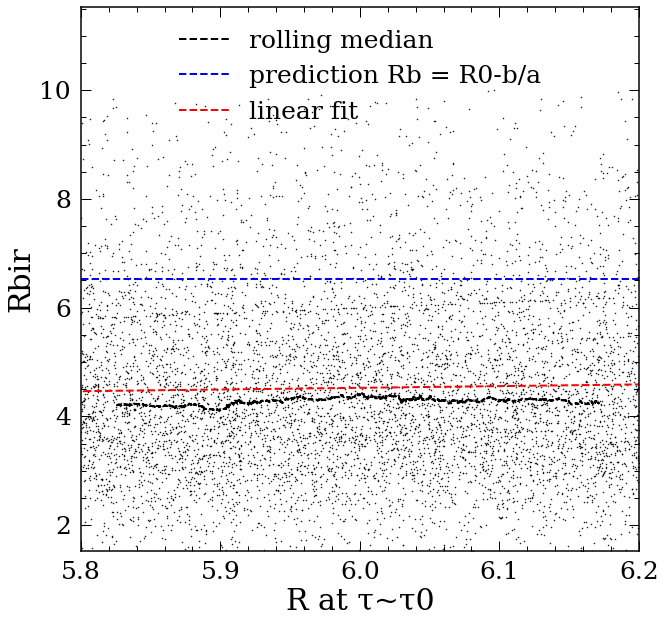

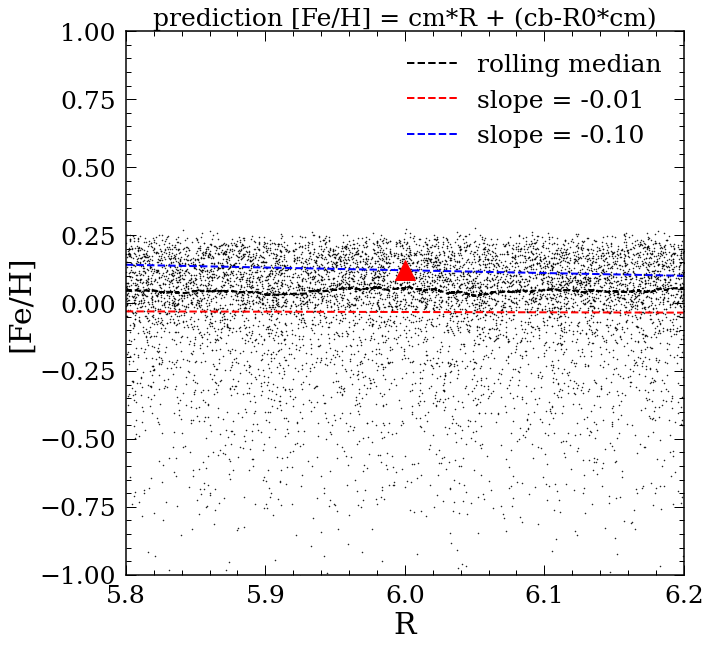

In [1634]:
plt.figure()
plt.plot(r,rbir,'k.',markersize=1)
plt.plot(r_rm,rbir_rm,'k--',label='rolling median')
plt.plot([R0-0.2,R0+0.2],np.ones(2)*(R0-b/a),'b--',label='prediction Rb = R0-b/a')
plt.plot([-1,10],p([-1,10]),'r--',label='linear fit')
plt.xlim([R0-0.2,R0+0.2])
plt.ylim([(R0-b/a)-5,(R0-b/a)+5])
plt.xlabel('R at τ~τ0')
plt.ylabel('Rbir')
plt.legend()


plt.figure()
plt.plot(r_feh,feh,'k.',markersize=1)
plt.plot(r_feh_rm,feh_rm,'k--',label='rolling median')
p_feh = fitpoints(r_feh[abs(r_feh-R0)<0.2],feh[abs(r_feh-R0)<0.2])
plt.xlabel('R')
plt.ylabel('[Fe/H]')
plt.plot([R0-0.2,R0+0.2],p_feh([R0-0.2,R0+0.2]),'r--', label = 'slope = %.2f'%(p_feh[1]))
plt.plot([R0-0.2,R0+0.2],np.array([R0-0.2,R0+0.2])*cm+cb-cm*R0,'b--', label = 'slope = %.2f'%(cm))
plt.plot(R0,cb,'r^',markersize=20)
plt.xlim([R0-0.2,R0+0.2])
plt.ylim([-1,1])
plt.legend()
plt.title('prediction [Fe/H] = cm*R + (cb-R0*cm)',fontsize=25)


## test different R0s and see where it breaks down

In [1635]:
"""
t0 = 15
R0 = 6

Ndata = 70
R0_range = np.linspace(0,15,Ndata)
scatters = np.zeros(Ndata)
biases = np.zeros(Ndata)

theta_t2_diff = np.zeros(Ndata)
Rbir_diff = np.zeros(Ndata)
feh_diff = np.zeros(Ndata)

averbir = np.zeros(Ndata)
average = np.zeros(Ndata)

thrbir = np.zeros(Ndata)
thfeh = np.zeros(Ndata)

fehslope = np.zeros(Ndata)
thslope = np.zeros(Ndata)

data_ct = data.loc[(data['age'])<2]
data_t0 = data.loc[data['age']>13.2]
for i in trange(len(R0_range)):
    data_ct_s = data_ct.loc[abs(data_ct['R']-R0_range[i])<0.2]
    radius = 0.2
    if len(data_ct_s)==0:
        continue
    data_ct_s = data_ct_s.dropna(subset=['feh','R', 'age', 'Rbir'])
    args = data_ct_s['feh'], data_ct_s['R'], data_ct_s['age']/t0
    args_name = '$θ_{[Fe/H]}$', '$θ_R$', '$θ_τ$'
    X = list(args)
    X_names = list(args_name)
    for a, b in combinations_with_replacement(args, 2):
        X.append(a * b)

    for a, b in combinations_with_replacement(args_name, 2):
        if a==b=='$θ_{[Fe/H]}$':
            X_names.append('$θ_{[Fe/H]^2}$')
        elif a==b=='$θ_R$':
            X_names.append('$θ_{R^2}$')
        elif a==b=='$θ_τ$':
            X_names.append('$θ_{τ^2}$')
        else:
            X_names.append(str(a + '*' + b))

    X = np.array(X).T
    
    X = np.array(X)[:,np.array([1,0,1,0,0,1,0,0,1], dtype=bool)]
    X_names = np.array(X_names)[np.array([1,0,1,0,0,1,0,0,1], dtype=bool)]
    
    Ntrain = int(0.8*np.shape(X)[0])
    y = data_ct_s['Rbir'].values

    # Choose stars at random and split.
    shuffle_inds = np.arange(len(y))
    np.random.shuffle(shuffle_inds)
    train_inds = shuffle_inds[:Ntrain]
    test_inds = shuffle_inds[Ntrain:]
    y_train, X_train = y[train_inds], X[train_inds, :]
    y_test, X_test = y[test_inds], X[test_inds, :]

    weights = train(y_train, X_train)

    A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
    y_predict = np.dot(weights.T, A.T)
    
    scatters[i] = np.std(y_test-y_predict)
    biases[i]  = np.mean(y_test-y_predict)
    
    allnames = np.append(['$θ_C$'],X_names)
    lasttao = {allnames[i]:weights[i] for i in range(len(allnames))}


    cm = 1/lasttao['$θ_{[Fe/H]}$']
    a = lasttao['$θ_{[Fe/H]}$*$θ_τ$']*cm**2
    cb = ((lasttao['$θ_C$']-R0)*cm)
    b = (lasttao['$θ_τ$']+a*cb/cm**2)*cm

    theta_t2_diff[i] = abs(-(cb/cm)*((a/cm)**2+a/2/cm)+(2*a+cm)*(b)/2/cm**2-lasttao['$θ_{τ^2}$'])
    data_t0_s = data_t0.loc[abs(data_t0['R']-R0_range[i])<0.2]
    radius = 0.2
    if len(data_t0_s)==0:
        continue
        
    data_t0_s = data_t0_s.sort_values(by='R')
    
    r = data_t0_s['R'].dropna().values
    rbir = data_t0_s['Rbir'].dropna().values

    r_feh = data['R'].values
    feh = data['feh'].values
    
    p = fitpoints(r, rbir)
    Rbir_diff[i] = p(R0_range[i])
    thrbir[i] = (R0_range[i]-b/a)

    p_feh = fitpoints(r_feh[abs(r_feh-R0_range[i])<0.2],feh[abs(r_feh-R0_range[i])<0.2])
    feh_diff[i] = p_feh(R0_range[i])
    thfeh[i] = (R0_range[i]*cm+cb-cm*R0_range[i])
    
    average[i] = np.mean(data.loc[abs(r_feh-R0_range[i])<0.2]['age'])
    averbir[i] = np.mean(data.loc[abs(r_feh-R0_range[i])<0.2]['Rbir'])
    fehslope[i] = p_feh[1]
    thslope[i] = cm


    
m_r = (fehslope!=0)
plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
plt.plot(R0_range[m_r], scatters[m_r],'k-o')
#plt.plot(R0_range[m_r], scatters_all[m_r],'b-o')
plt.ylim([0,1.5])
plt.xlabel('R0 [kpc]')
plt.ylabel('scattering [kpc]')

plt.subplot(3,3,2)
plt.plot(R0_range[m_r], biases[m_r],'k-o')
plt.ylim([-1,1])
plt.xlabel('R0 [kpc]')
plt.ylabel('bias [kpc]')

plt.subplot(3,3,3)
plt.plot(R0_range[m_r], theta_t2_diff[m_r],'k-o')
plt.ylim([0,1000])
plt.plot([0,8],[0,0],'r--')
plt.xlabel('R0 [kpc]')
plt.ylabel('|$θ_{τ^2}^{theory}-θ_{τ^2}^{true}$|')

plt.subplot(3,3,4)
plt.plot(R0_range[m_r], Rbir_diff[m_r],'k-o', label='$R_b(R_0)^{true}$')
plt.plot(R0_range[m_r], thrbir[m_r],'r-o', label='$R_b(R_0)^{theory}$')
plt.ylim([-8,20])
plt.legend()
plt.xlabel('R0 [kpc]')
plt.ylabel('$R_b(R_0)$ [kpc]')

plt.subplot(3,3,5)
plt.plot(R0_range[m_r], feh_diff[m_r],'k-o', label='$[Fe/H](R_0)^{true}$')
plt.plot(R0_range[m_r], thfeh[m_r],'r-o', label='$[Fe/H](R_0)^{theory}$')
plt.ylim([-0.5,0.5])
plt.legend()
plt.xlabel('R0 [kpc]')
plt.ylabel('$[Fe/H](R_0)$ [dex]')

plt.subplot(3,3,6)
plt.plot(R0_range[m_r], fehslope[m_r],'k-o', label='$\\nabla [Fe/H]^{true}$')
plt.plot(R0_range[m_r], thslope[m_r],'r-o', label='$\\nabla [Fe/H]^{theory}$')
plt.ylim([-0.2,0.2])
plt.legend()
plt.xlabel('R0 [kpc]')
plt.ylabel('$\\nabla [Fe/H]$ [dex/kpc]')

plt.subplot(3,3,7)
plt.plot(R0_range[m_r], averbir[m_r],'k-o')
plt.xlabel('R0 [kpc]')
plt.ylabel('median $R_b$ around $R_0$ [kpc]')

plt.subplot(3,3,8)
plt.plot(R0_range[m_r], average[m_r],'k-o')
plt.xlabel('R0 [kpc]')
plt.ylabel('median Age around $R_0$ [Gyr]')

plt.tight_layout()
"""

"\nt0 = 15\nR0 = 6\n\nNdata = 70\nR0_range = np.linspace(0,15,Ndata)\nscatters = np.zeros(Ndata)\nbiases = np.zeros(Ndata)\n\ntheta_t2_diff = np.zeros(Ndata)\nRbir_diff = np.zeros(Ndata)\nfeh_diff = np.zeros(Ndata)\n\naverbir = np.zeros(Ndata)\naverage = np.zeros(Ndata)\n\nthrbir = np.zeros(Ndata)\nthfeh = np.zeros(Ndata)\n\nfehslope = np.zeros(Ndata)\nthslope = np.zeros(Ndata)\n\ndata_ct = data.loc[(data['age'])<2]\ndata_t0 = data.loc[data['age']>13.2]\nfor i in trange(len(R0_range)):\n    data_ct_s = data_ct.loc[abs(data_ct['R']-R0_range[i])<0.2]\n    radius = 0.2\n    if len(data_ct_s)==0:\n        continue\n    data_ct_s = data_ct_s.dropna(subset=['feh','R', 'age', 'Rbir'])\n    args = data_ct_s['feh'], data_ct_s['R'], data_ct_s['age']/t0\n    args_name = '$θ_{[Fe/H]}$', '$θ_R$', '$θ_τ$'\n    X = list(args)\n    X_names = list(args_name)\n    for a, b in combinations_with_replacement(args, 2):\n        X.append(a * b)\n\n    for a, b in combinations_with_replacement(args_name, 2):\

## Frankle2018

for $\tau$ ~ $\tau_0$:

- $R_b ~ \frac{1}{C_m}\rm{[Fe/H]} - \frac{F_m}{C_m}$

for $\tau$ << $\tau_0$:

- $R_b$ ~ $\frac{1}{c_m}\rm{[Fe/H]} - \gamma(\frac{F_m}{C_m}+R_0-\frac{C_b}{C_m^2})(\tau/\tau_0) + \gamma(\gamma-1)[\frac{F_m}{2C_m}+\frac{R_0}{2}-\frac{C_b}{2 C_m}](\tau/\tau_0)^2 + R_0 - \frac{C_b}{C_m}$


$C_m := \nabla\rm{[Fe/H]}(0)$; $C_b := \rm{[Fe/H]}(R_0, 0)$

In [1636]:
t0 = 12
R0 = 6
data_ct = data.loc[(data['age'])<2]
data_ct = data_ct.loc[abs(data_ct['R']-R0)<0.2]
data_ct = data_ct.dropna(subset=['feh','R', 'age', 'Rbir'])
args = data_ct['feh'], data_ct['R'], data_ct['age']/t0
args_name = '$θ_{[Fe/H]}$', '$θ_R$', '$θ_τ$'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    if a==b=='$θ_{[Fe/H]}$':
        X_names.append('$θ_{[Fe/H]^2}$')
    elif a==b=='$θ_R$':
        X_names.append('$θ_{R^2}$')
    elif a==b=='$θ_τ$':
        X_names.append('$θ_{τ^2}$')
    else:
        X_names.append(str(a + '*' + b))
    

X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(724, 9) (9,) 3


In [1637]:
X = np.array(X)[:,np.array([1,0,1,0,0,0,0,0,1], dtype=bool)]
X_names = np.array(X_names)[np.array([1,0,1,0,0,0,0,0,1], dtype=bool)]

X_names

array(['$θ_{[Fe/H]}$', '$θ_τ$', '$θ_{τ^2}$'], dtype='<U18')

In [1638]:
# Define the number of training and validating stars.
y = data_ct['Rbir'].values

# Choose stars at random and split.
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

weights = train(y_train, X_train)

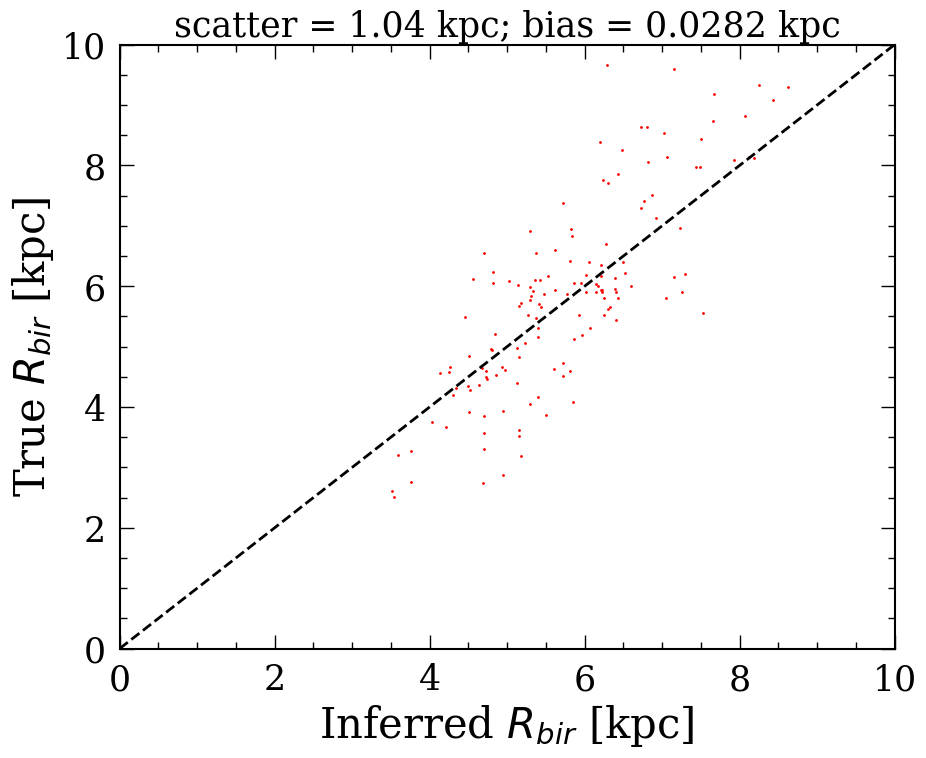

In [1639]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_predict.T, y_test, s=1, c='r')
plt.plot(xs, xs, "k--")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("Inferred $R_{bir}$ [kpc]")
plt.ylabel("True $R_{bir}$ [kpc]")
plt.title('scatter = %.2f kpc; bias = %.4f kpc'%(scatter, bias),fontsize=25)
plt.savefig('Rbirth.png')

In [1640]:
allnames = np.append(['$θ_C$'],X_names)
lasttao = {allnames[i]:weights[i] for i in range(len(allnames))}

lasttao, len(allnames)

({'$θ_C$': 7.793954700123523,
  '$θ_{[Fe/H]}$': -16.27369116404945,
  '$θ_τ$': -1.3690601410216476,
  '$θ_{τ^2}$': -4.520905433728248},
 4)

In [1641]:
print('assumed τ0 = 12 Gyr, R0 = 6:')
print('\n')
cm = 1/lasttao['$θ_{[Fe/H]}$']
print('cm', cm)
cb = ((lasttao['$θ_C$']-R0)*cm)
print('cb', cb)
γ = 2*(lasttao['$θ_{τ^2}$']/lasttao['$θ_τ$'])+1
print('γ', γ)
Rn = R0-cb/cm
Fm = (-(lasttao['$θ_τ$']/γ)-lasttao['$θ_C$'])*cm
print('Fm', Fm)

assumed τ0 = 12 Gyr, R0 = 6:


cm -0.061448874131833156
cb -0.11023649656610086
γ 7.604392748377828
Fm 0.46786676669650046


### test these values on the $\tau$ ~ $\tau0$ limit for Rb, and to test the slope and [Fe/H] around R0

[Fe/H](0,12) from extrapolation of red line 0.03564926301646676
[Fe/H](0,12) from prediction 0.46786676669650046


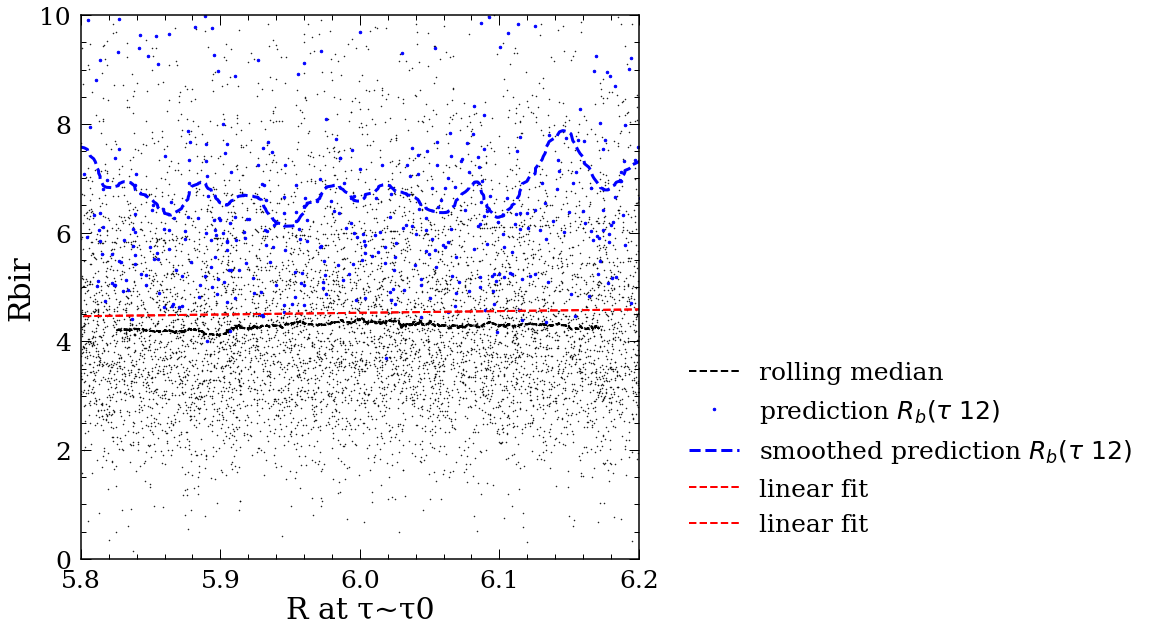

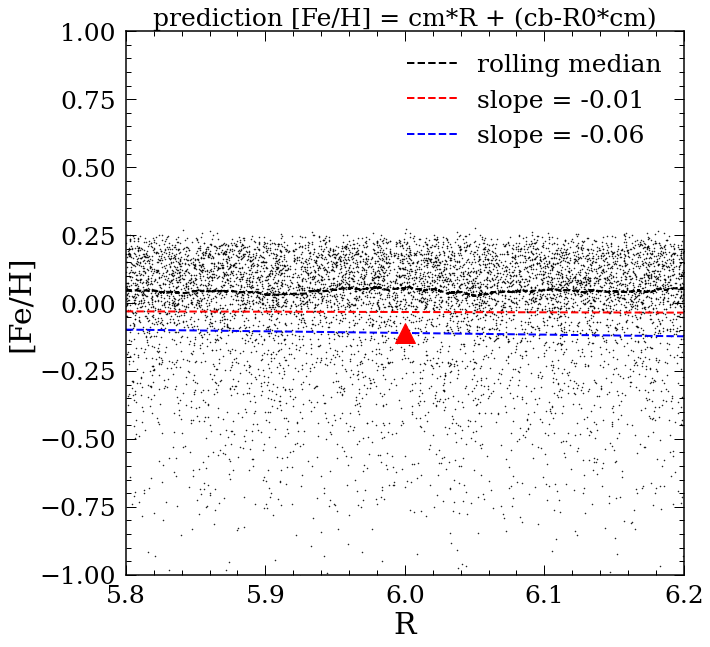

In [1642]:
from scipy.ndimage import gaussian_filter1d

plt.figure()
plt.plot(r,rbir,'k.',markersize=1)
plt.plot(r_rm,rbir_rm,'k--',label='rolling median')
rbir_sort, feh_t0_sort = zip(*sorted(zip(rbir, feh_t0)))
rbpredict = (1/cm)*np.array(feh_t0_sort)-Fm/cm
plt.plot(np.array(rbir_sort),rbpredict,'b.',markersize=5, label='prediction $R_b(τ~12)$')
rbpredict = gaussian_filter1d(rbpredict, 10)
plt.plot(np.array(rbir_sort),rbpredict,'b--', linewidth=3, label='smoothed prediction $R_b(τ~12)$')
plt.plot([-1,10],p([-1,10]),'r--',label='linear fit')
plt.plot([-1,10],p([-1,10]),'r--',label='linear fit')
plt.xlim([R0-0.2,R0+0.2])
plt.ylim([0,10])
plt.xlabel('R at τ~τ0')
plt.ylabel('Rbir')
plt.legend(loc=3,bbox_to_anchor=(1.05, 0., 0.5, 0.5))


plt.figure()
plt.plot(r_feh,feh,'k.',markersize=1)
plt.plot(r_feh_rm,feh_rm,'k--',label='rolling median')
p_feh = fitpoints(r_feh[abs(r_feh-R0)<0.2],feh[abs(r_feh-R0)<0.2])
plt.xlabel('R')
plt.ylabel('[Fe/H]')
plt.plot([R0-0.2,R0+0.2],p_feh([R0-0.2,R0+0.2]),'r--', label = 'slope = %.2f'%(p_feh[1]))
plt.plot([R0-0.2,R0+0.2],np.array([R0-0.2,R0+0.2])*cm+cb-cm*R0,'b--', label = 'slope = %.2f'%(cm))
plt.plot(R0,cb,'r^',markersize=20)
plt.xlim([R0-0.2,R0+0.2])
plt.ylim([-1,1])
plt.legend()
plt.title('prediction [Fe/H] = cm*R + (cb-R0*cm)',fontsize=25)
print('[Fe/H](0,12) from extrapolation of red line', p_feh(0))
print('[Fe/H](0,12) from prediction', Fm)



# Tylor series with sympy

In [1700]:
import sympy
feh, Cb, Cm, R0, tau, tau0, a, b, eps, Fm, gamma = sympy.symbols('[Fe/H] C_b C_m R_0 τ τ_0 a b eps F_m γ')

f = (feh-Cb)/(a*sympy.ln(1-tau/tau0)+Cm)-b/(a+Cm/sympy.ln(1-tau/tau0))+R0

exp1 = f.subs(feh,feh*eps).subs(tau,tau*eps).series(eps).removeO().subs(eps,1)


In [1701]:
f2 = feh/Cm-Fm/Cm+(Fm/Cm+R0-Cb/Cm)*(1-tau/tau0)**gamma

exp2 = f2.subs(feh,feh*eps).subs(tau,tau*eps).series(eps).removeO().subs(eps,1)



In [1702]:
import warnings
warnings.filterwarnings('ignore')

Minchev2018


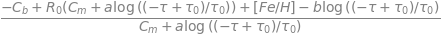

In [1703]:
print('Minchev2018')
sympy.simplify(f)

In [1704]:
print('Frankle2018')
sympy.simplify(f2)

Frankle2018


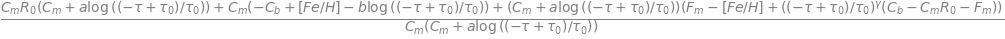

In [1705]:
sympy.simplify(f-f2)